In [1]:
import math

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.stats as stats
from datetime import datetime,date

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
us_covid_with_dates = pd.read_pickle('../datasets/us_covid_with_dates.pkl')

In [4]:
us_covid_with_dates.head()

2020-01-21 00:00:00  2020-01-22 00:00:00  2020-01-23 00:00:00  \
state                                                                       
Alabama                       0                  0.0                  0.0   
Alaska                        0                  0.0                  0.0   
Arizona                       0                  0.0                  0.0   
California                    0                  0.0                  0.0   
Colorado                      0                  0.0                  0.0   

            2020-01-24 00:00:00  2020-01-25 00:00:00  2020-01-26 00:00:00  \
state                                                                       
Alabama                     0.0                  0.0                  0.0   
Alaska                      0.0                  0.0                  0.0   
Arizona                     0.0                  0.0                  0.0   
California                  0.0                  0.0                  0.0   
Colorado                    0.0                  0.0                  0.0   

            2020-01-27 00:00:00  2020-01-28 00:00:00  2020-01-29 00:00:00  \
state                                                                       
Alabama                     0.0                  0.0                  0.0   
Alaska                      0.0                  0.0                  0.0   
Arizona                     0.0                  0.0                  0.0   
California                  0.0                  0.0                  0.0   
Colorado                    0.0                  0.0                  0.0   

            2020-01-30 00:00:00  ...  2020-04-01 00:00:00  \
state                            ...                        
Alabama                     0.0  ...            10.710711   
Alaska                      0.0  ...             7.518797   
Arizona                     0.0  ...             8.859784   
California                  0.0  ...            14.378933   
Colorado                    0.0  ...            11.906355   

            2020-04-02 00:00:00  2020-04-03 00:00:00  2020-04-04 00:00:00  \
state                                                                       
Alabama               14.828210            20.866142             6.384365   
Alaska                 2.097902             6.849315             8.333333   
Arizona               13.234253            10.562500            14.132278   
California            13.997555            12.323503             9.762113   
Colorado              11.416617            12.178112             9.373505   

            2020-04-05 00:00:00  2020-04-06 00:00:00  2020-04-07 00:00:00  \
state                                                                       
Alabama               12.737293             8.962520             9.521436   
Alaska                 9.467456             2.162162            11.640212   
Arizona               12.382368             8.638167             4.462475   
California             9.278052             8.012735             7.713093   
Colorado               8.220376             4.484848             4.969064   

            2020-04-08 00:00:00  2020-04-09 00:00:00  Effective Date  
state                                                                 
Alabama               13.746017            13.565426      2020-04-04  
Alaska                 6.161137             4.017857      2020-03-28  
Arizona                5.864078            10.711665      2020-03-31  
California             8.568985             6.028462      2020-03-19  
Colorado               4.162829             9.672856      2020-03-26  

[5 rows x 81 columns]

In [5]:
class State():
    
    def __init__(self, percent_increases, dates, name):
        '''
        percent_increases: floats with last entry being date in 
                                which the stay-at-home order was effective.
        dates: pandas._libs.tslibs.timestamps.Timestamp with last 
                    entry being 'Effective Date'
        name: string
        '''
        self.percent_increases = self.parse_increases(percent_increases)
        self.dates = self.parse_dates(dates, percent_increases)
        self.name = name
        self.stay_home_date = self.stay_home(percent_increases)
        self.random_color = random_color = np.random.rand(3,)
        self.p_value = self.calc_p_value()
    
    def parse_increases(self, perc_inc):
        '''Returns only the percent increases (takes away 0's and the 
        effective date)'''
        #strip perc_inc of stay-at-home order date
        perc_inc_ = perc_inc[:-1]
        
        #get only the percent increases that is more than 0
        perc_greater = perc_inc_[perc_inc_ > 0]
        
        return perc_greater
    
    def parse_dates(self, date, perc_inc):
        '''Returns only the days that have percent increases'''
        #strip perc_inc of stay-at-home order date
        perc_inc_ = perc_inc[:-1]
        
        #get only the data that is more than 0
        perc_greater = perc_inc_[perc_inc_ > 0]
        
        #strip dates of last entry
        date_ = date[:-1]
        
        #get only the dates that the perc_inc is more than 0
        dates_greater = date_[perc_inc_ > 0]
        
        return dates_greater
    
    def stay_home(self, perc_inc):
        '''Returns the day at which the state implemented stay-at-home order'''
        return perc_inc[-1]
    
    def plot_percent_changes(self, ax):
        '''Plots the percent increase per day
        and plots a vertical line at the stay_home_date in the same color'''
        ax.plot(self.dates, self.percent_increases, c=self.random_color,
                label=self.name)
        
        ax.axvline(self.stay_home_date, linestyle="--", c=self.random_color,
                  label = '{} Stay-Home Date'.format(self.name))

        
    # Hypothesis Testing
    def get_pre_increase(self):
        '''Returns only the data before social distancing was implented plus
        7 days (hypothetically how many days to actually see the effects)'''
        
        #define the federal social distancing date
        federal_dist_date = '2020-03-16'
        federal_dist_date = pd.to_datetime(federal_dist_date)
        
        #get the index where the federal social distancing date is at
        try:
            index_social = list(self.dates).index(federal_dist_date)
        except ValueError:
            index_social = 0
        
        return self.percent_increases[:index_social + 7]
    
    def get_post_increase(self):
        '''Returns only the data after social distancing was implented plus
        8 days (hypothetically how many days to actually see the effects)'''
        
        #define the federal social distancing date
        federal_dist_date = '2020-03-16'
        federal_dist_date = pd.to_datetime(federal_dist_date)
        
        #get the index where the federal social distancing date is at
        try:
            index_social = list(self.dates).index(federal_dist_date)
        except ValueError:
            index_social = 0
        
        return self.percent_increases[index_social + 8:]
    
    def calc_p_value(self):
        '''returns the calculated p-value from stats.ttest_ind'''
        stat, p_val = stats.ttest_ind(self.get_pre_increase(), 
                                      self.get_post_increase(), 
                                      equal_var = False)
        return p_val
    
    def plot_p_value(self, ax):
        '''Plots the p-value for the state on a bar chart per day
        and plots a horizontal line at the rejection threshold (0.05)'''
        
        ax.bar(self.name, self.p_value, label="{} p-value".format(self.name), 
               color= self.random_color, alpha=0.3)
        ax.axhline(0.05, linestyle="--", color="red", 
                 label='Rejection Threshold')
        #ax.set_xlabel(self.name)
        ax.legend()

In [6]:
def generate_labels(ax):
    '''generates labels and formats axes'''
    ax.legend(fontsize=14)
    
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 4))
    ax.set_xlabel('Date')
    ax.xaxis.label.set_size(20)
    
    
    ax.set_ylabel('Percent Change Per Day')
    ax.yaxis.label.set_size(20)

In [7]:
def plot_social_distance(ax, date):
    '''Plots vertical line on axis that shows the date at which social distancing was implemented.
    Inputs
    ------
    ax: matplotlib ax to plot on
    dates: pandas._libs.tslibs.timestamps.Timestamp with last entry being 'Effective Date'
    label: string
    
    Returns
    -------
    None   
    
    '''
    ax.axvline(date, color="green", linestyle=":", 
               label='Federal Social Distancing Date')

In [8]:
def get_social_distance_date():
    '''returns datetime object of the federal social distancing date'''
    federal_dist_date = '2020-03-16'
    federal_dist_date = pd.to_datetime(federal_dist_date)
    return federal_dist_date

## Make a list of State objects

In [12]:
all_states = []

for each_state in us_covid_with_dates.index:
    each_state = State(us_covid_with_dates.loc[each_state, :], 
                   us_covid_with_dates.columns, each_state)
    all_states.append(each_state)

In [13]:
length = len(all_states)

### Plot every state on its own plot. save each to a file.

/Users/tjwoo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


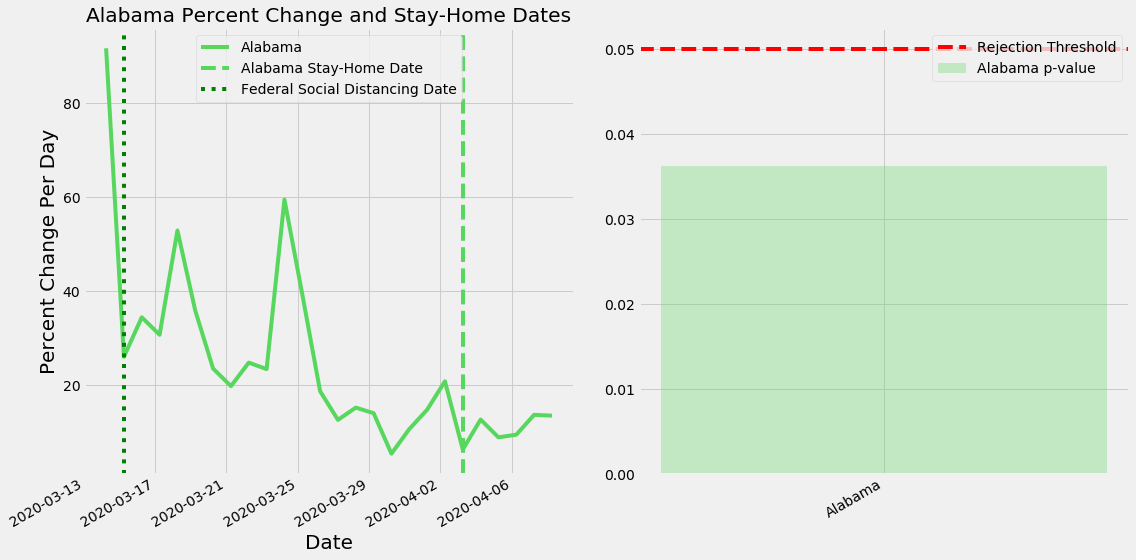

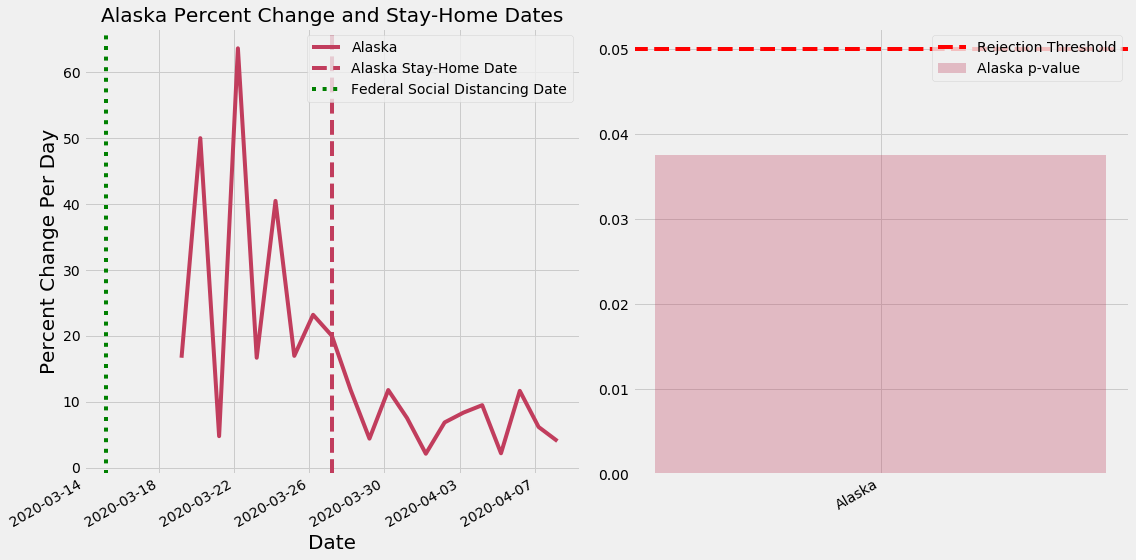

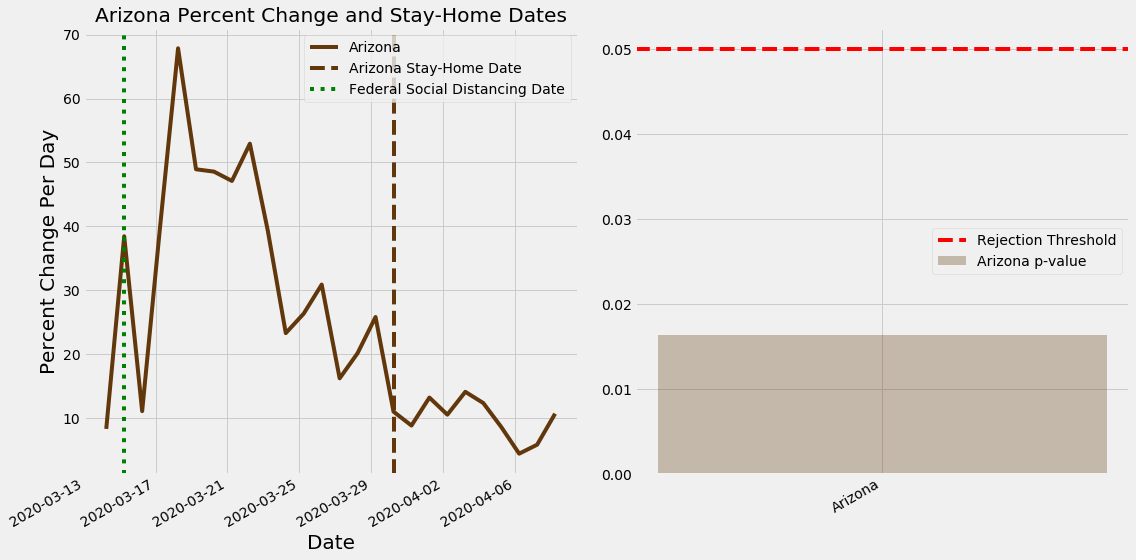

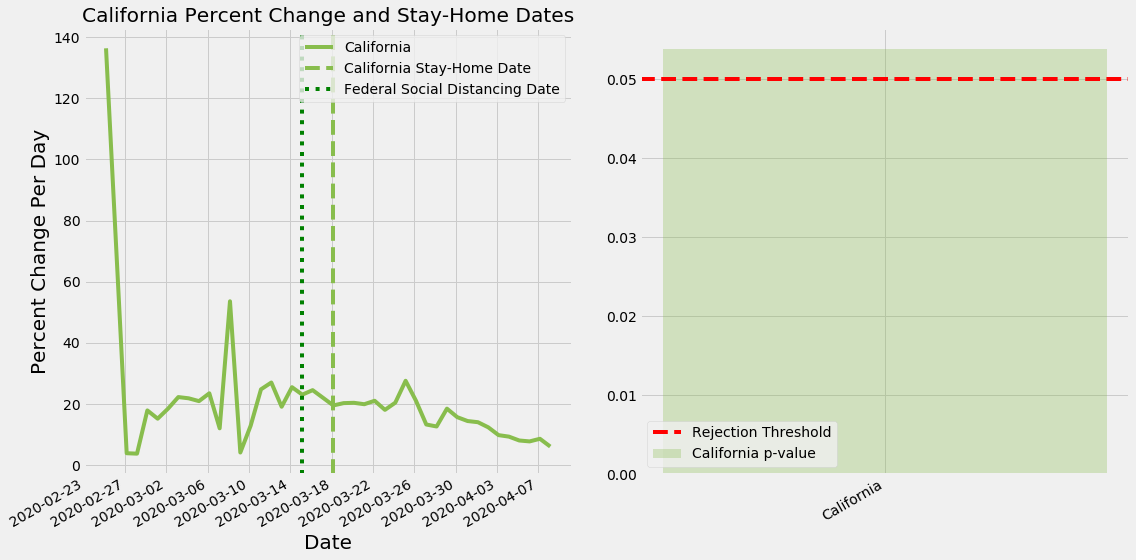

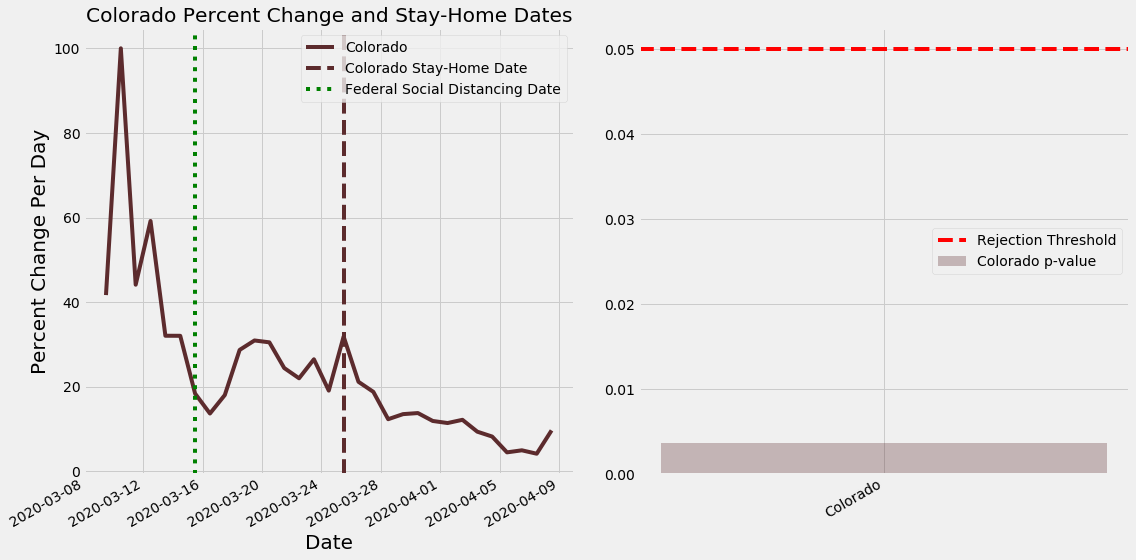

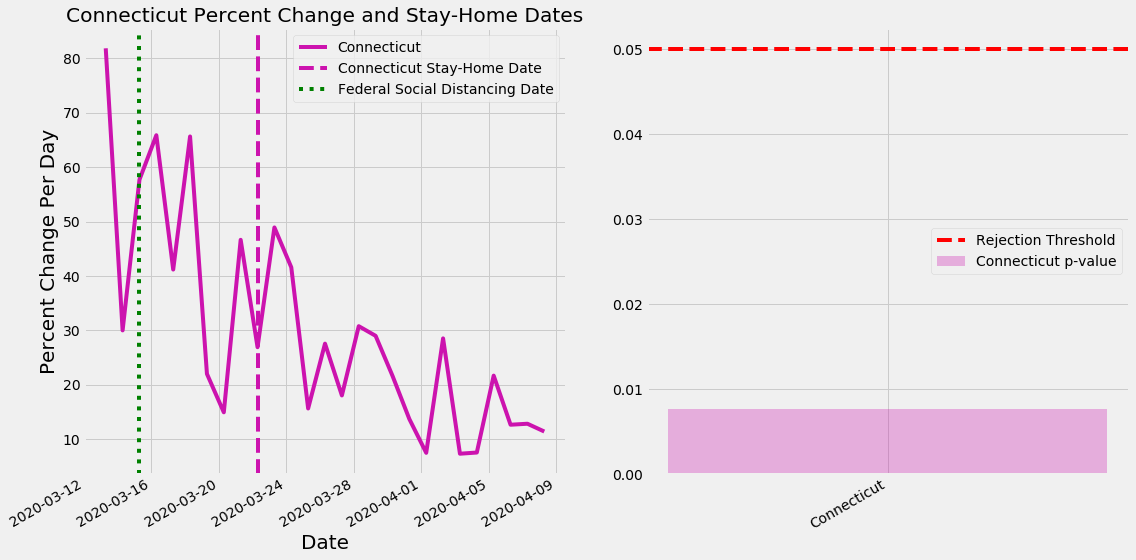

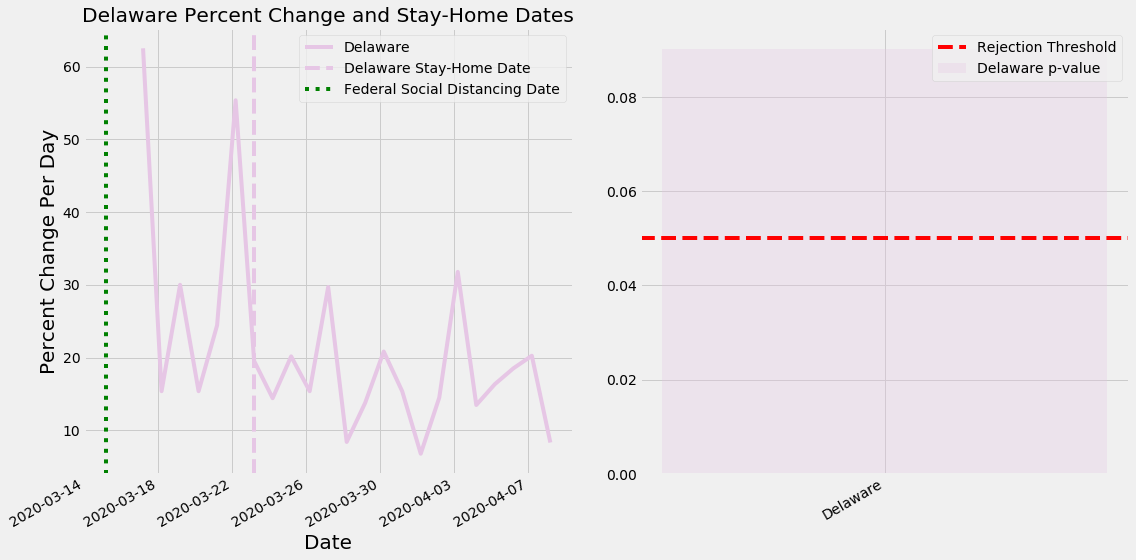

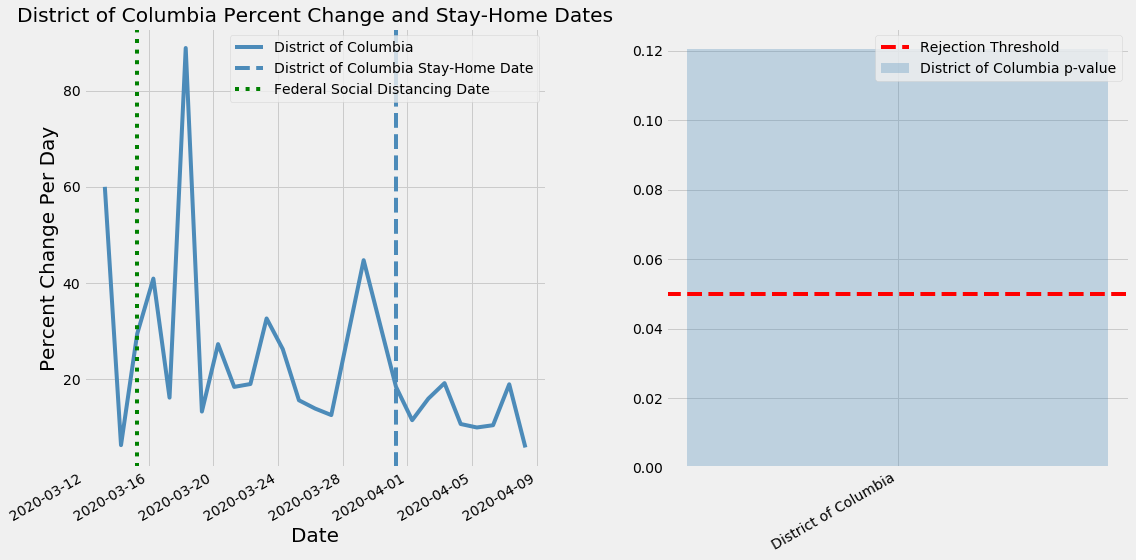

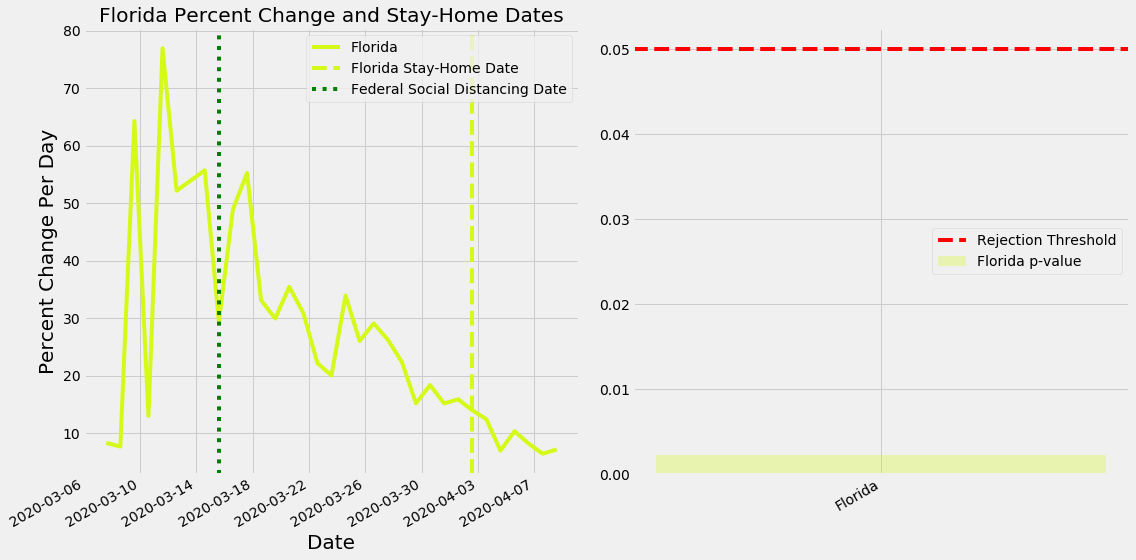

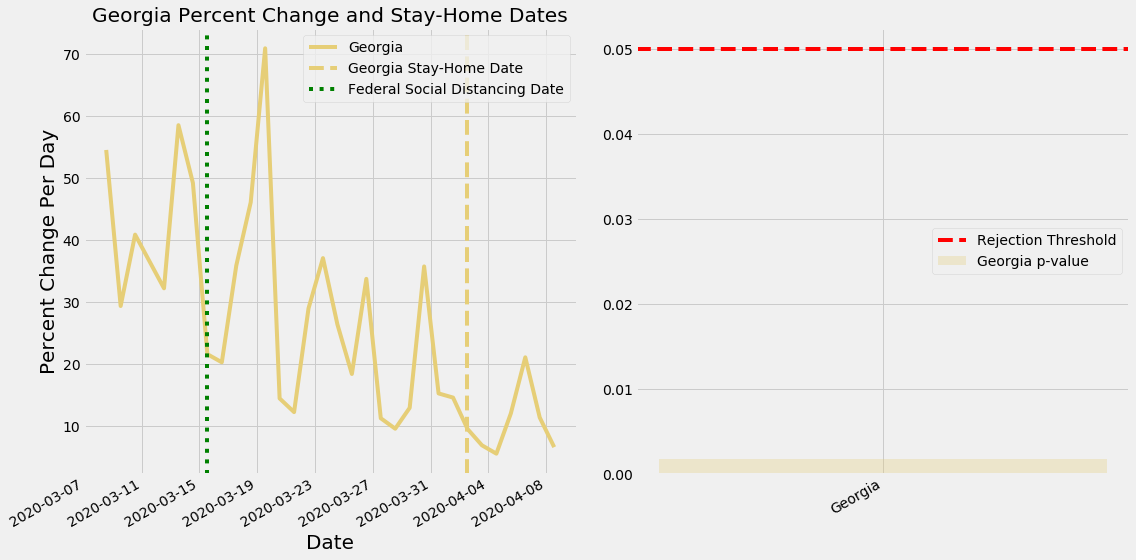

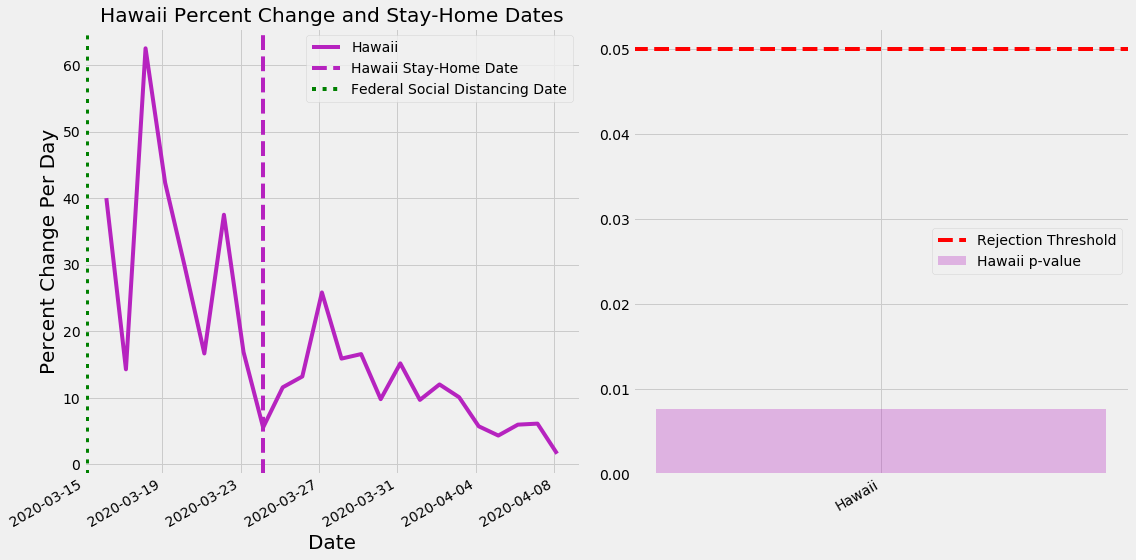

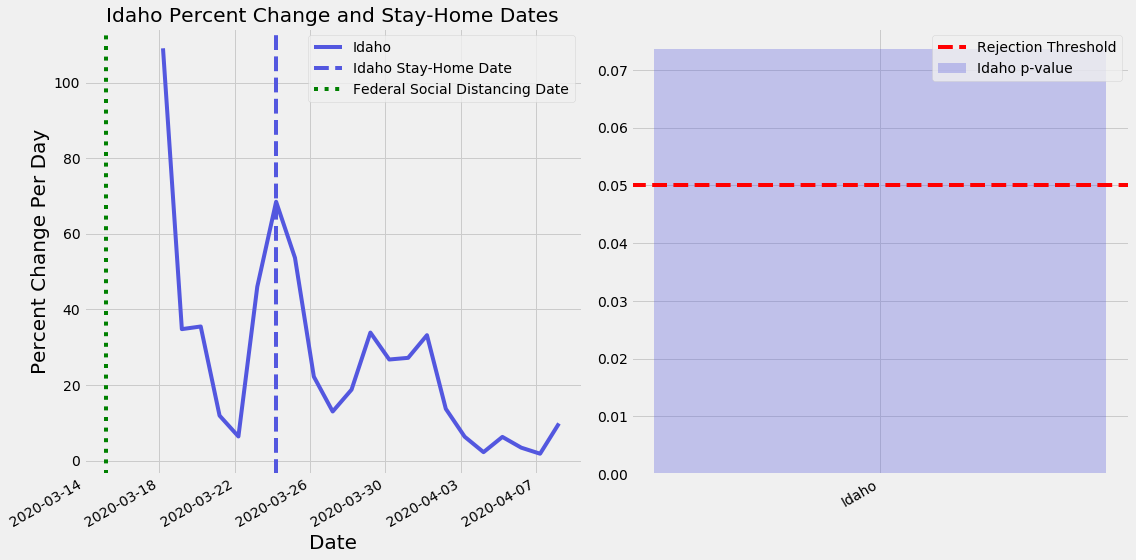

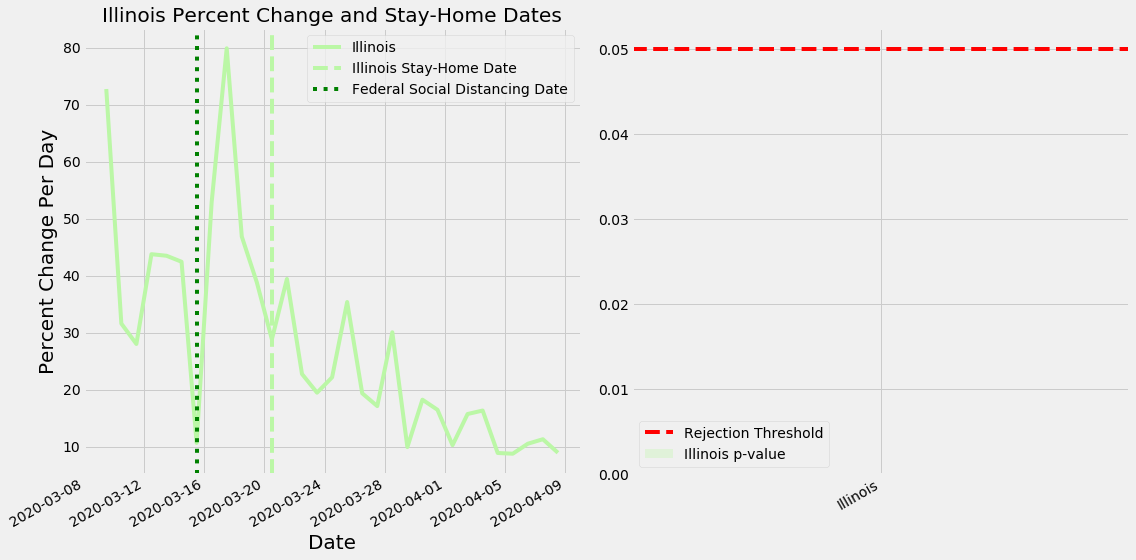

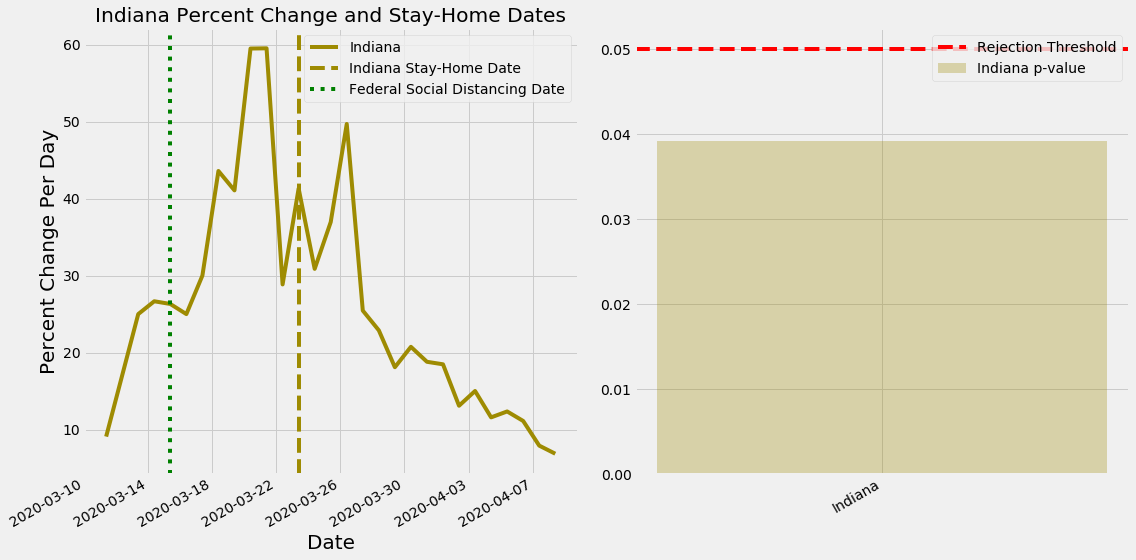

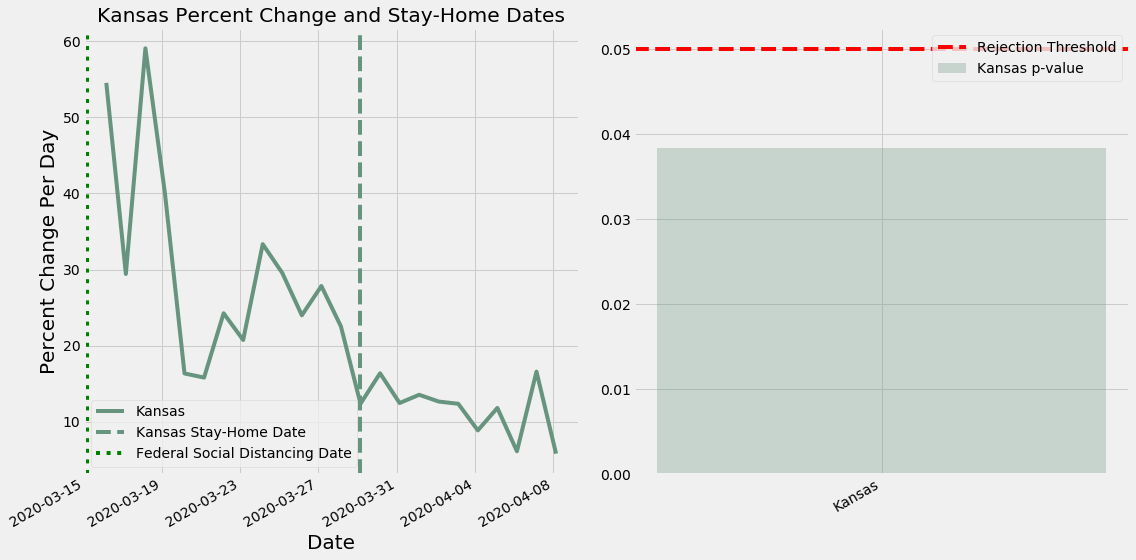

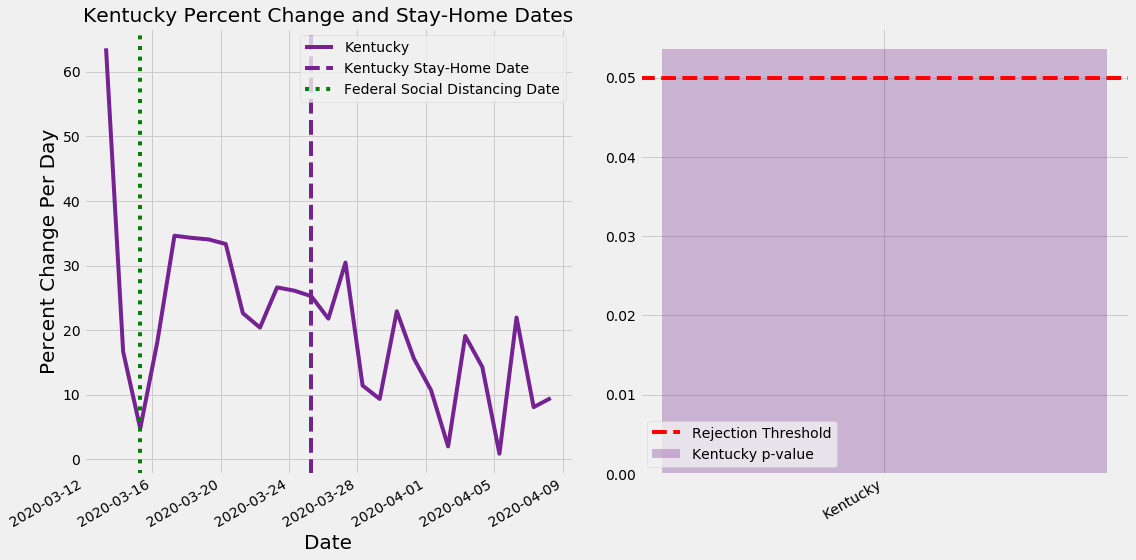

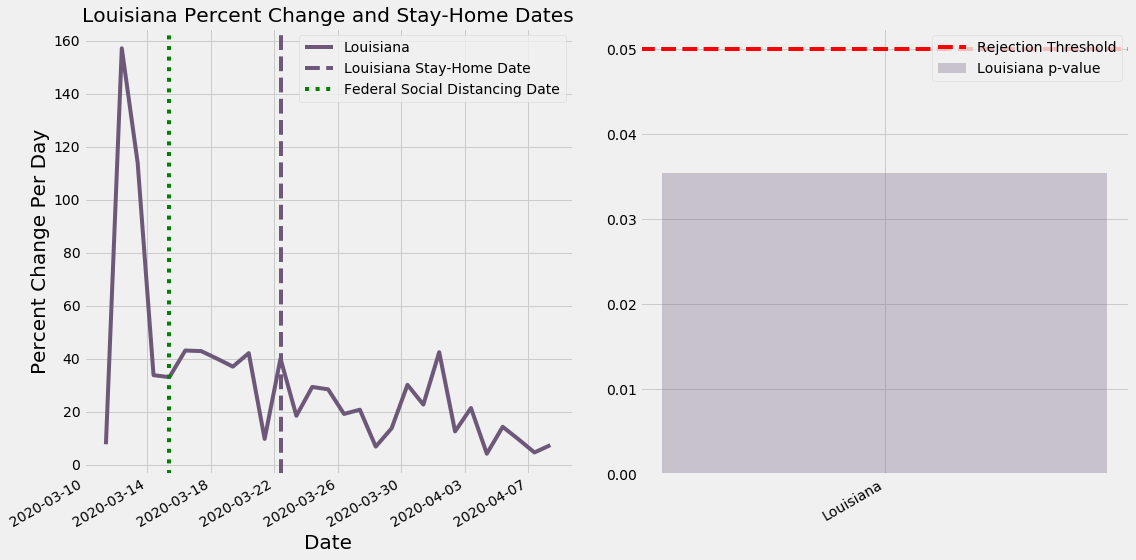

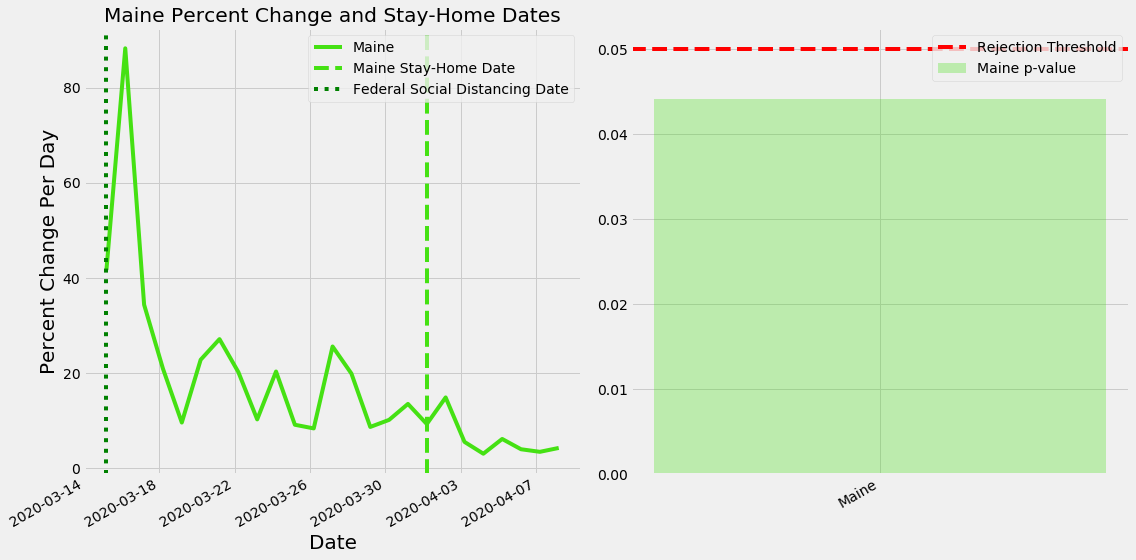

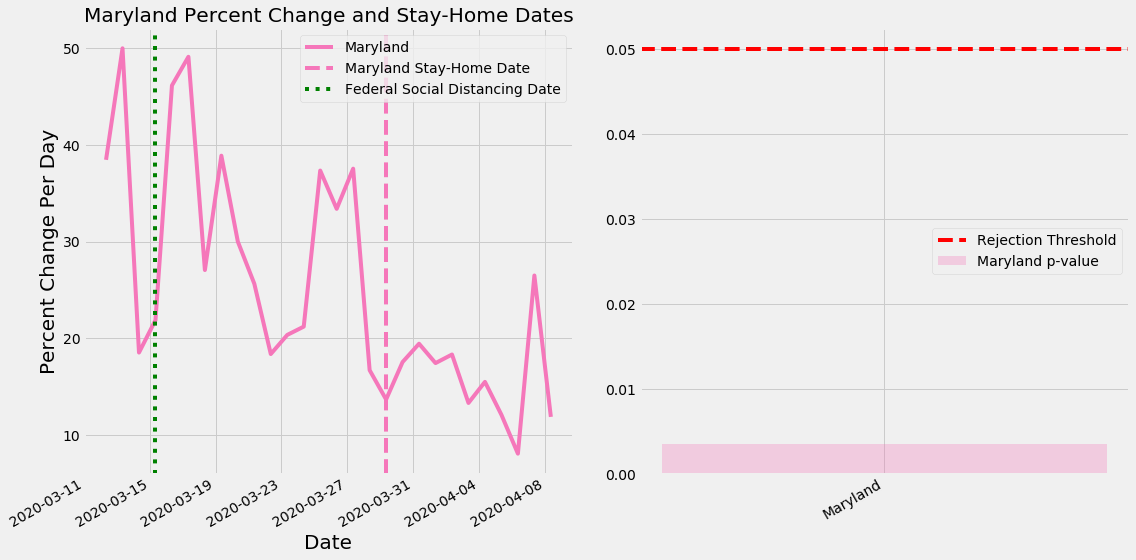

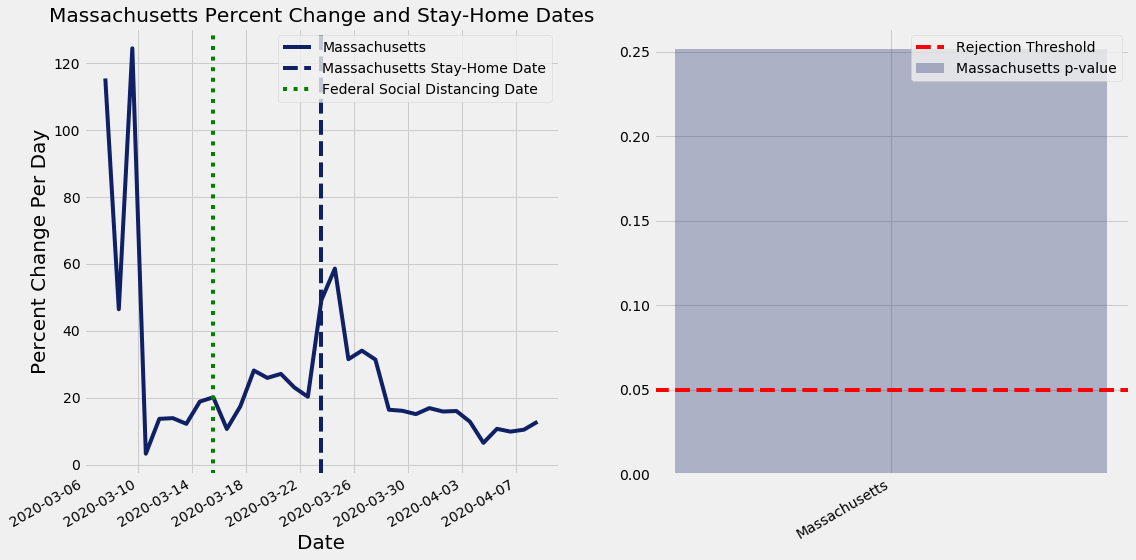

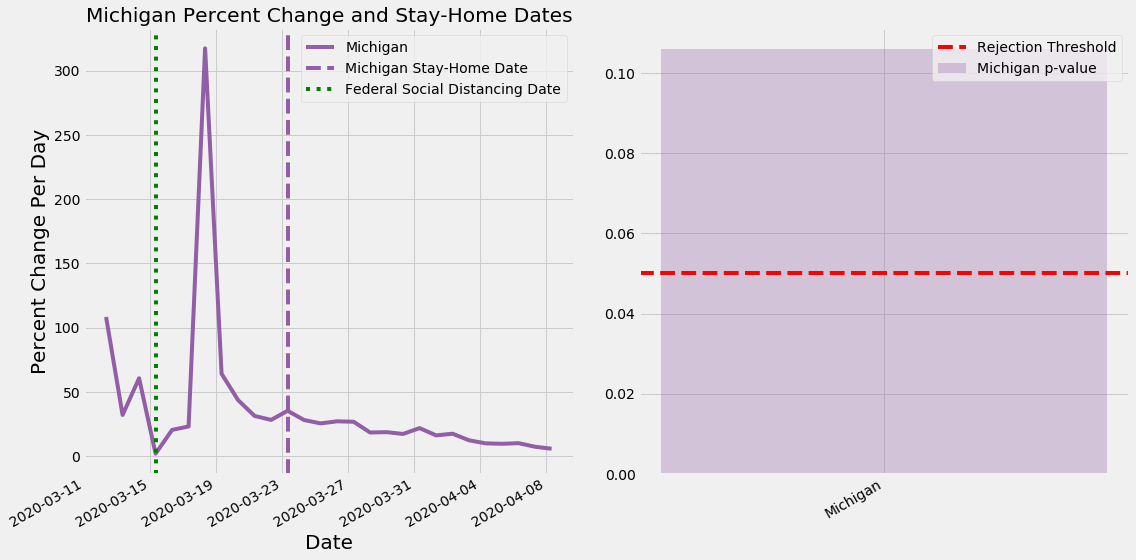

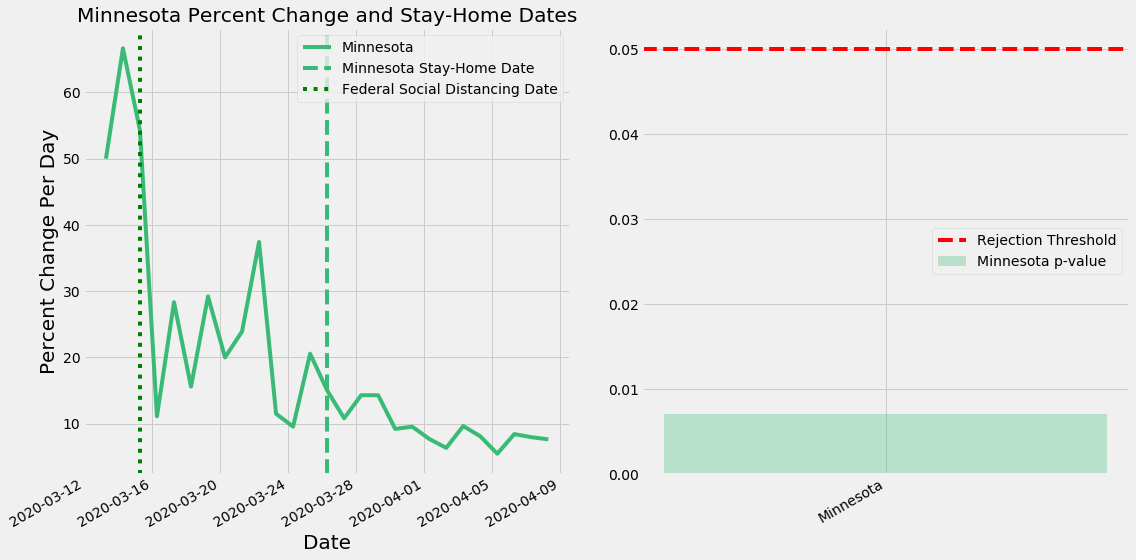

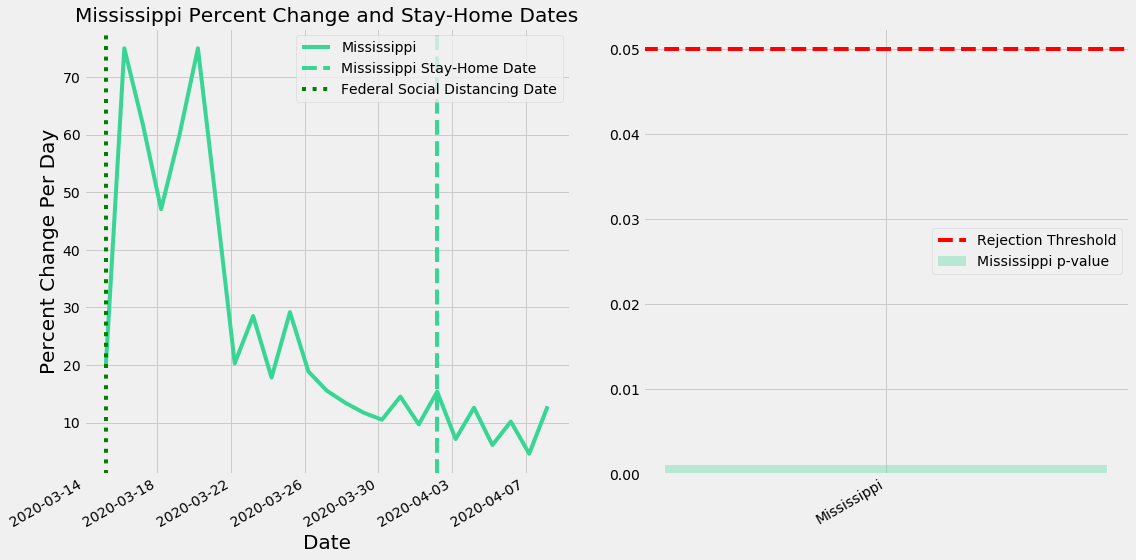

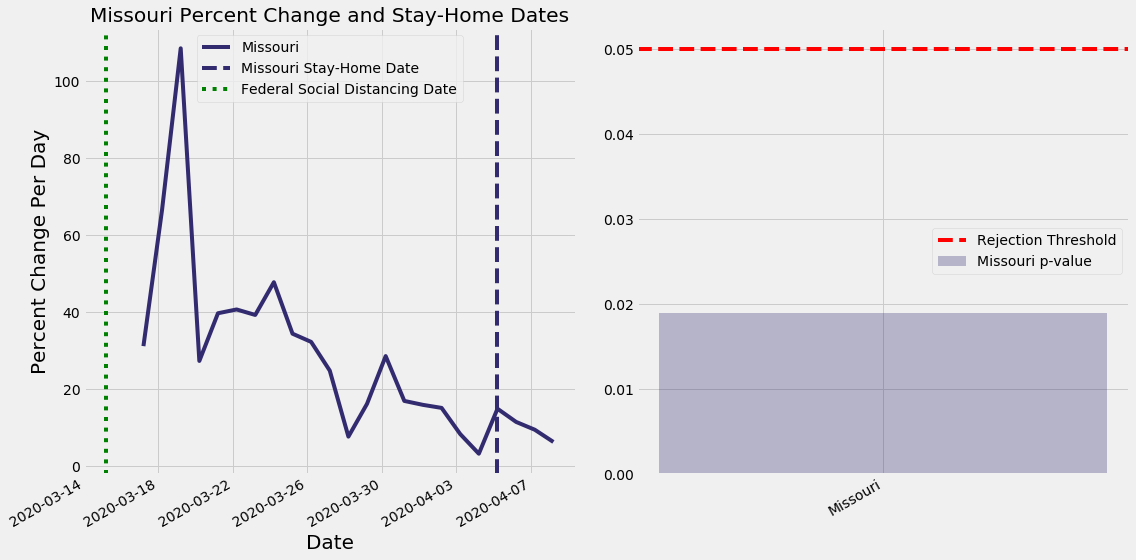

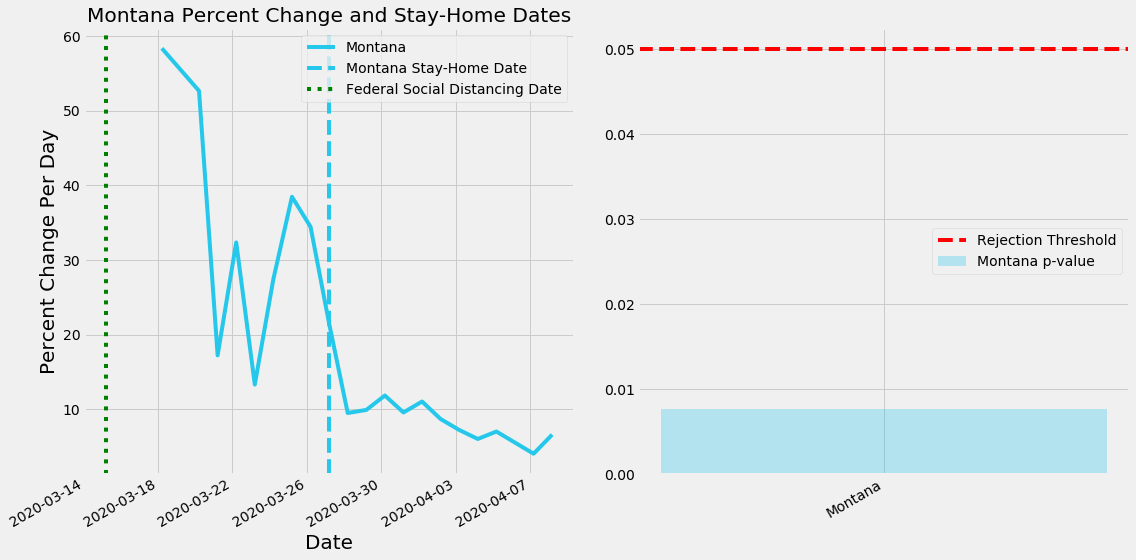

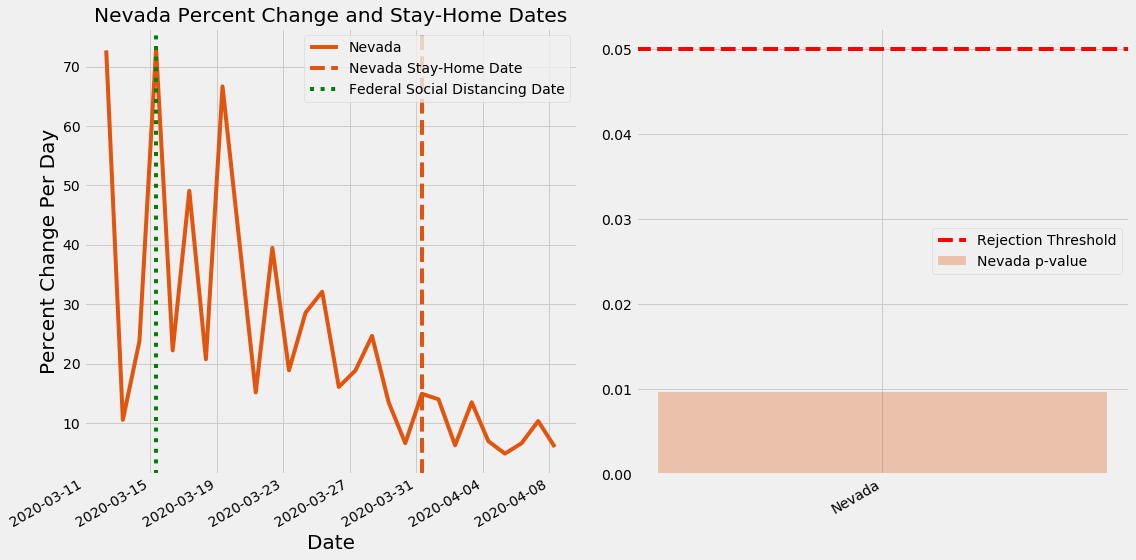

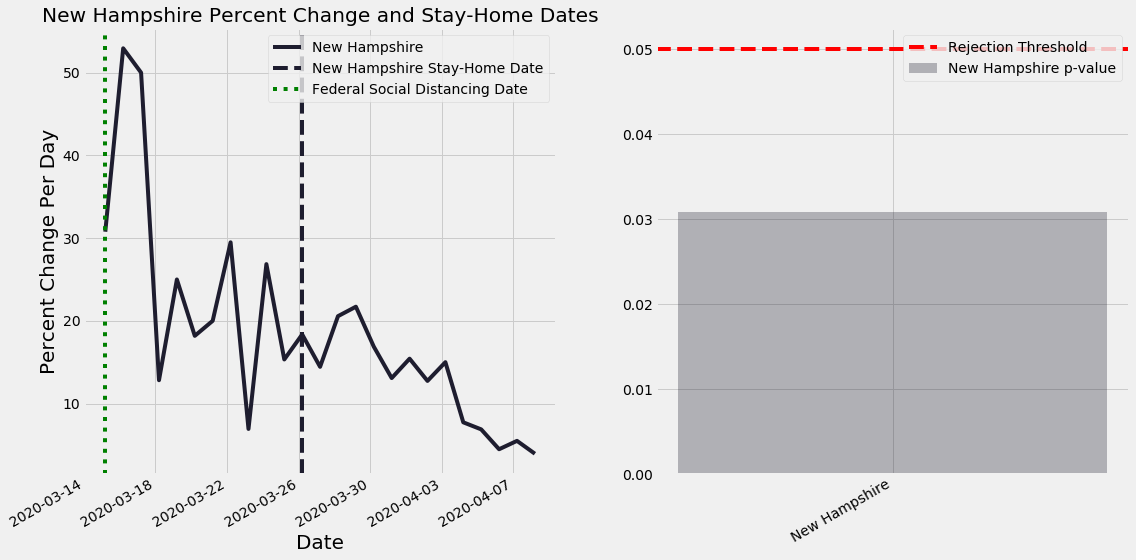

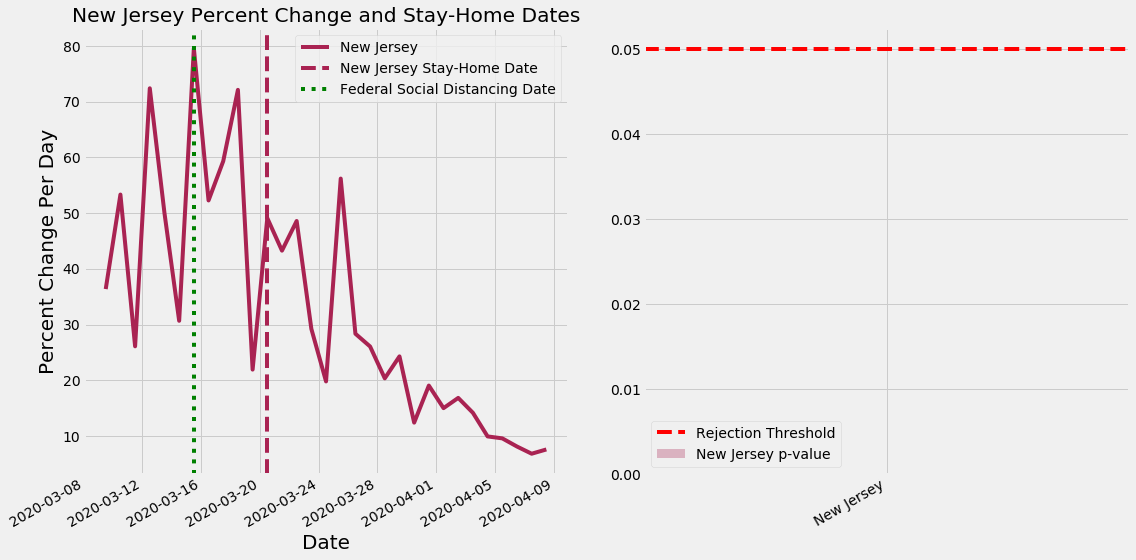

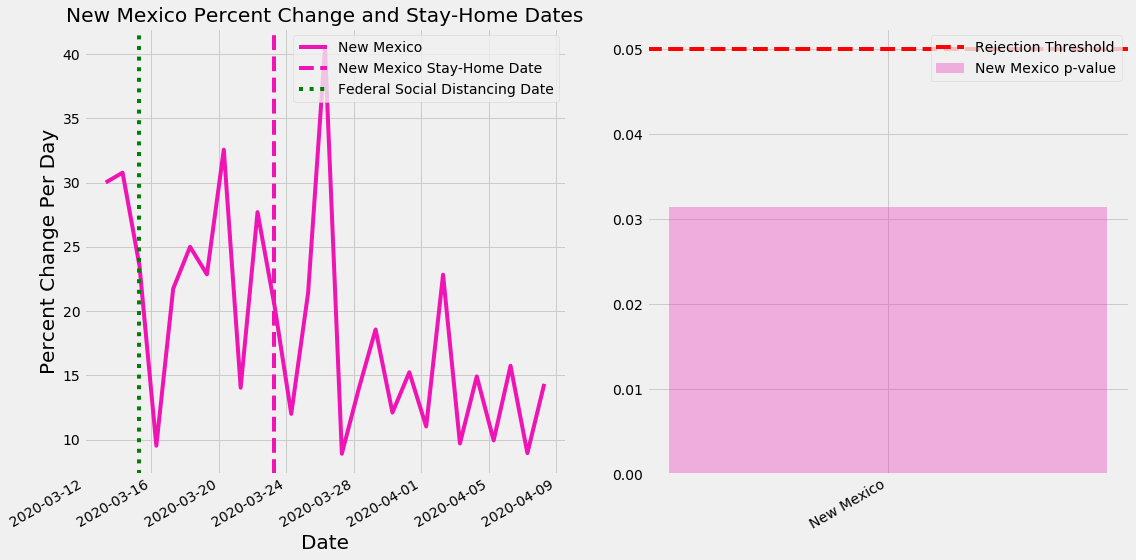

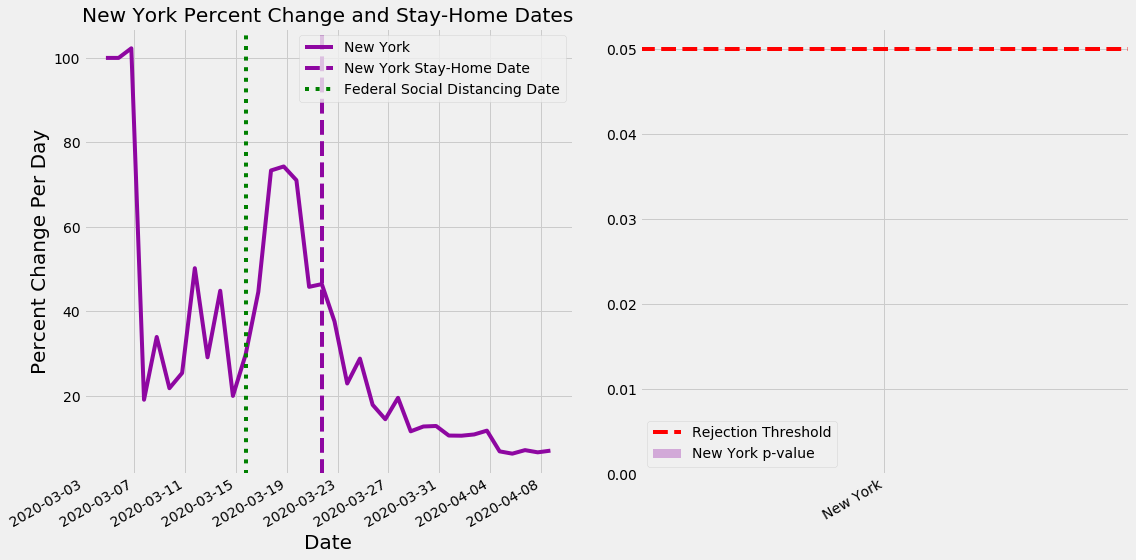

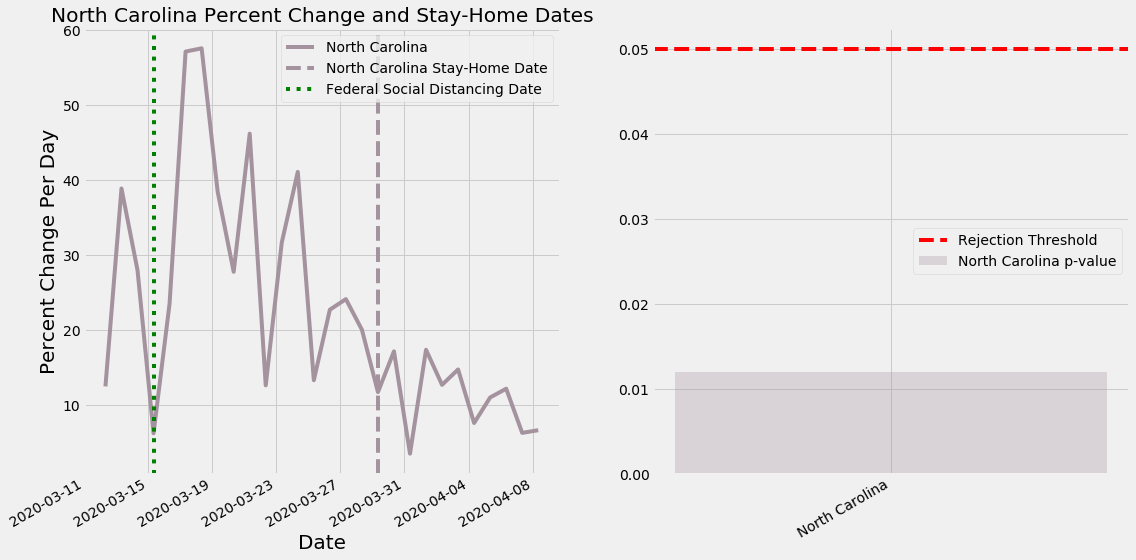

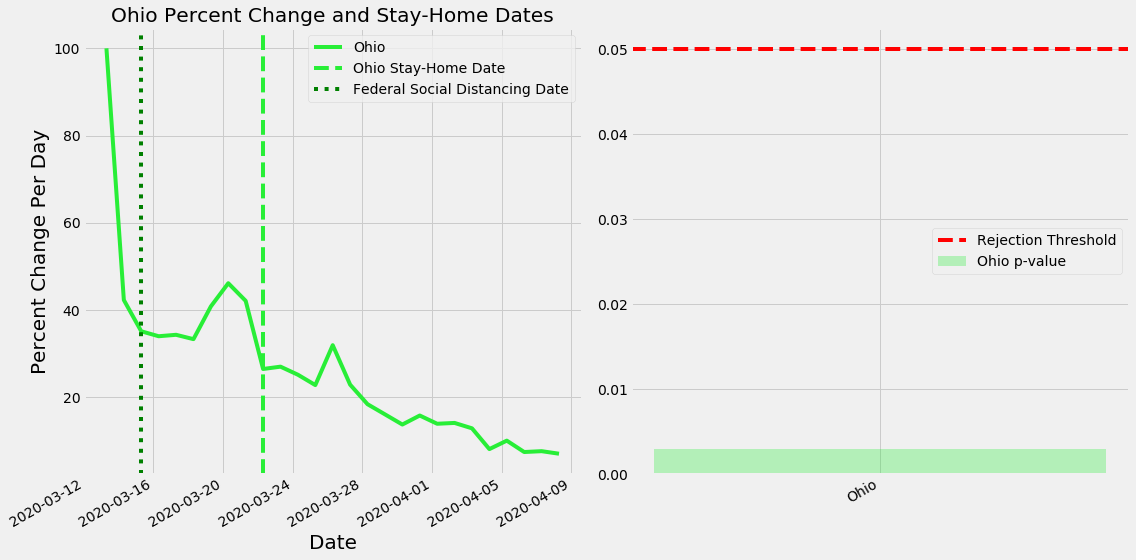

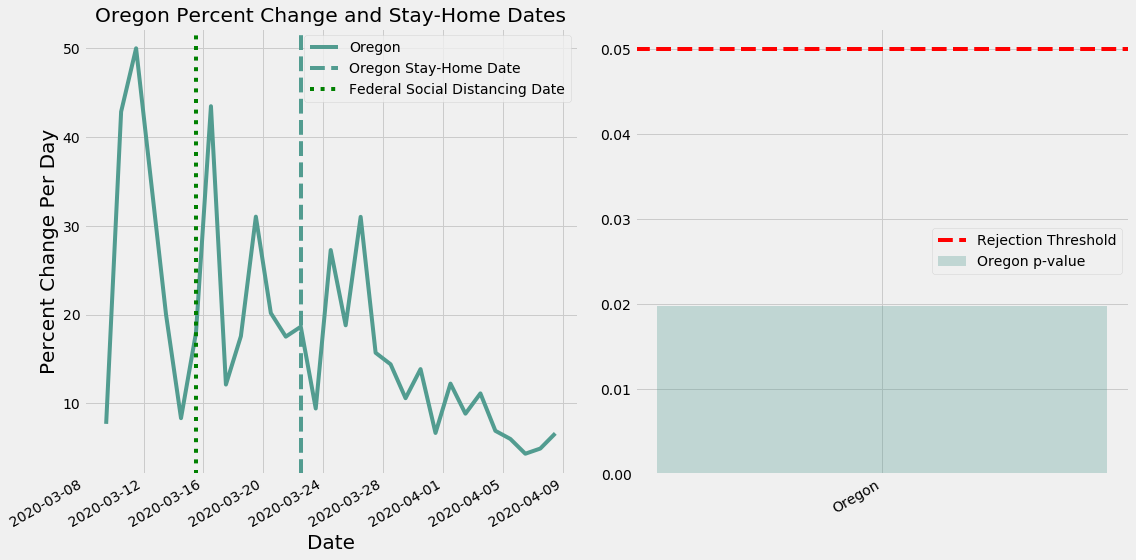

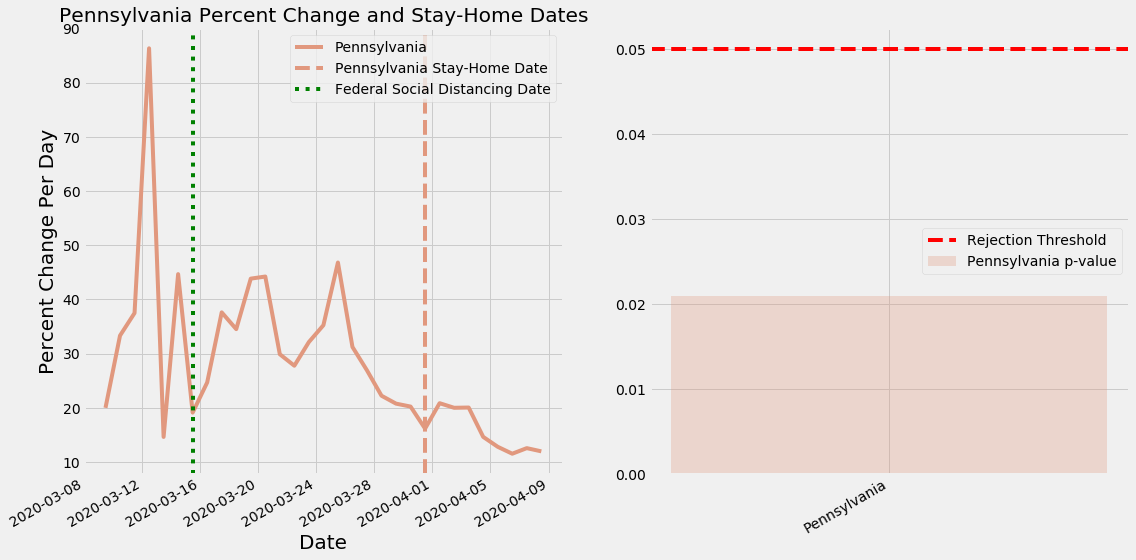

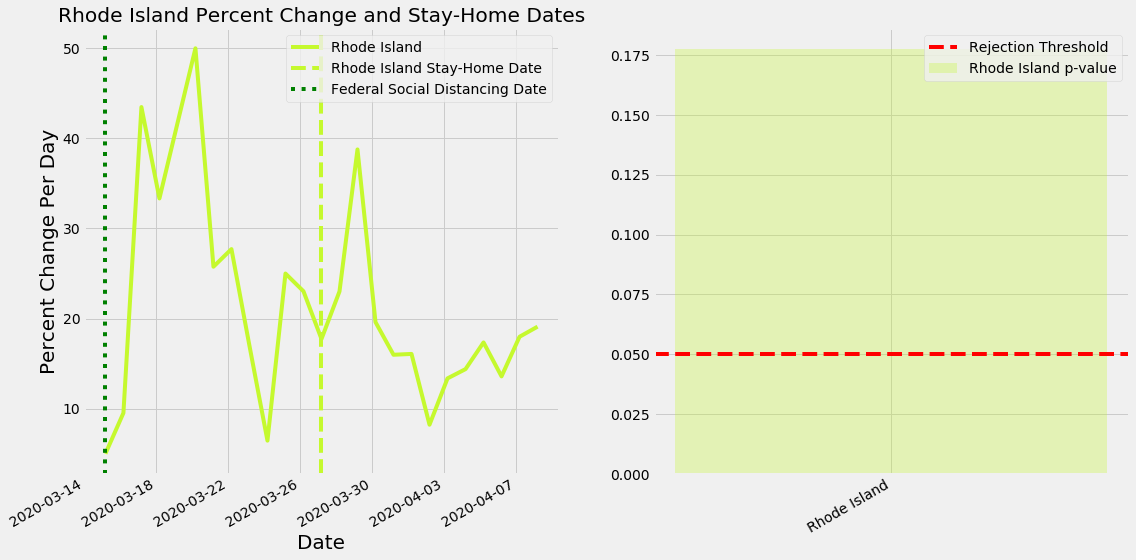

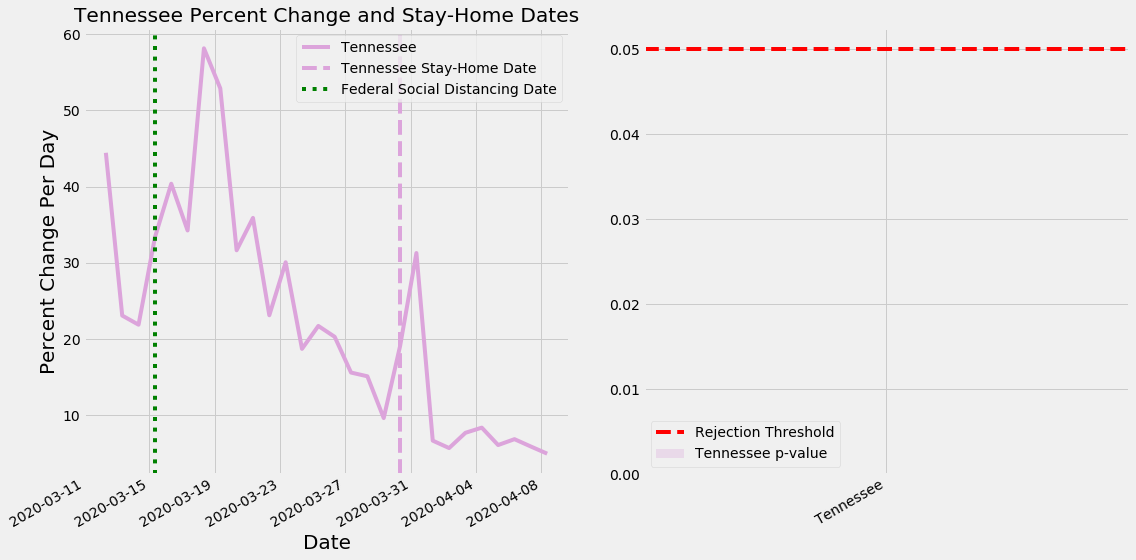

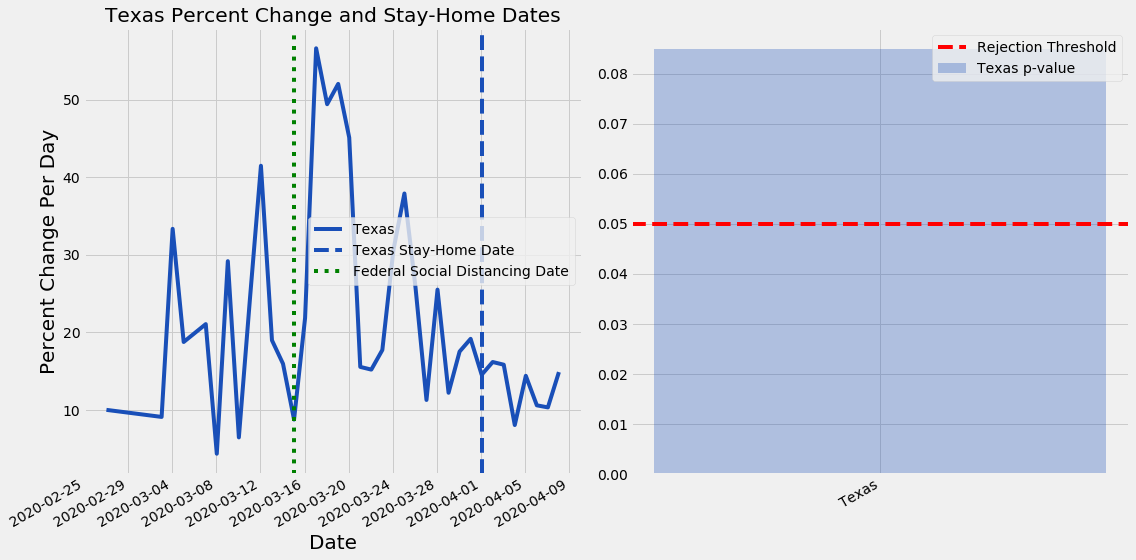

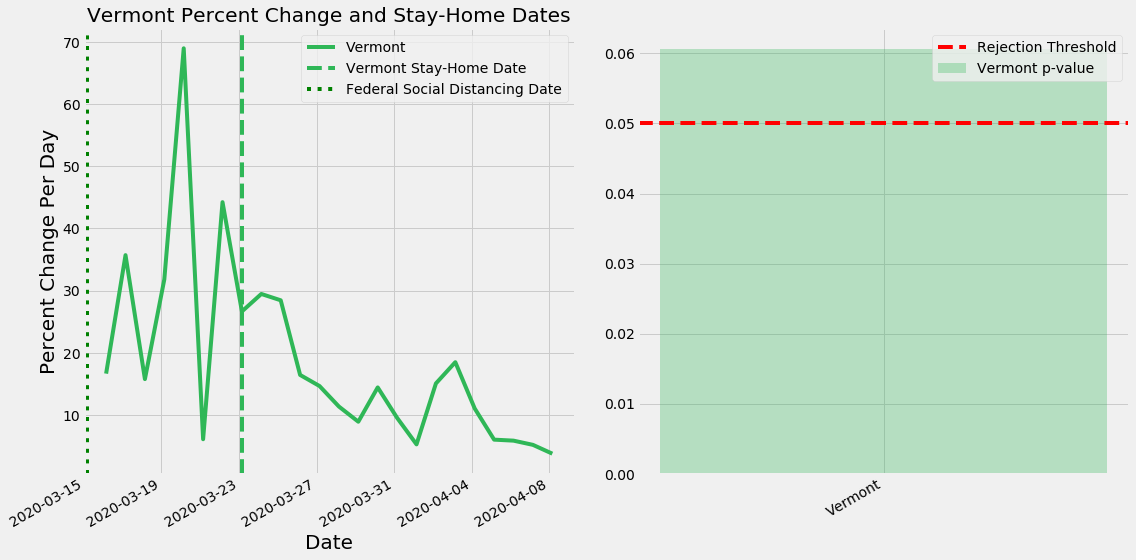

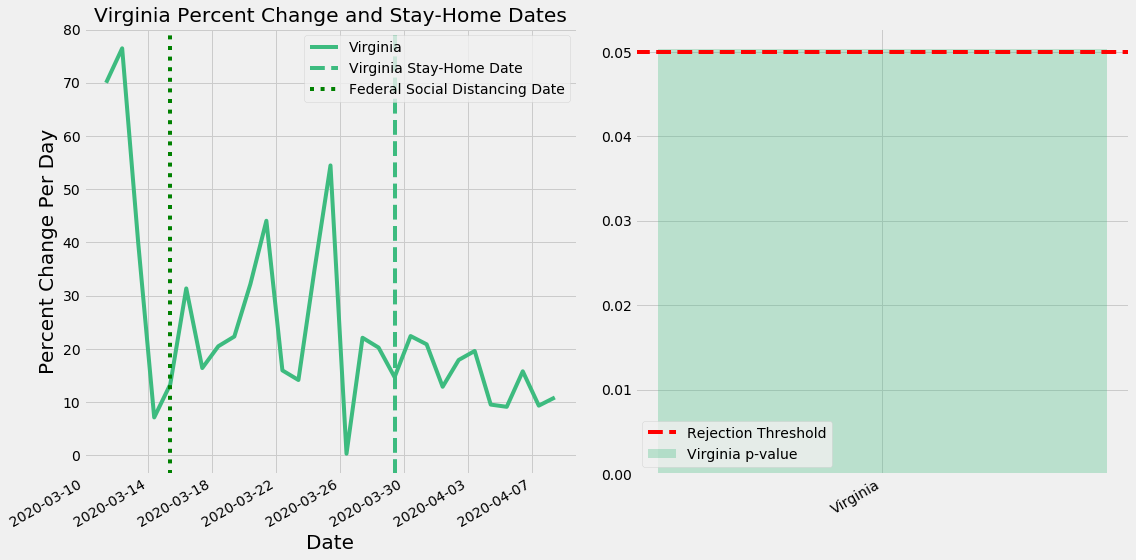

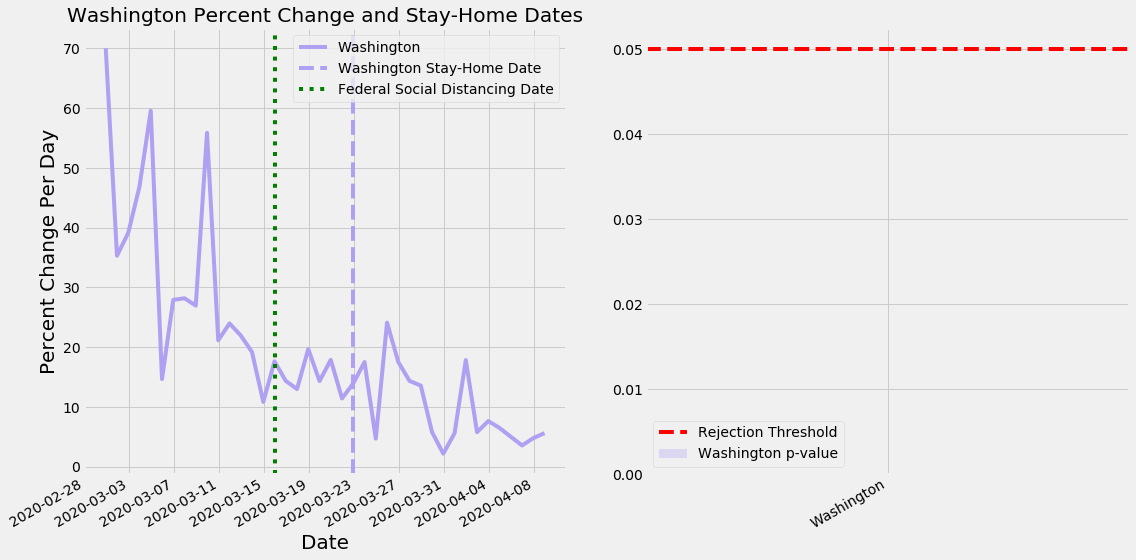

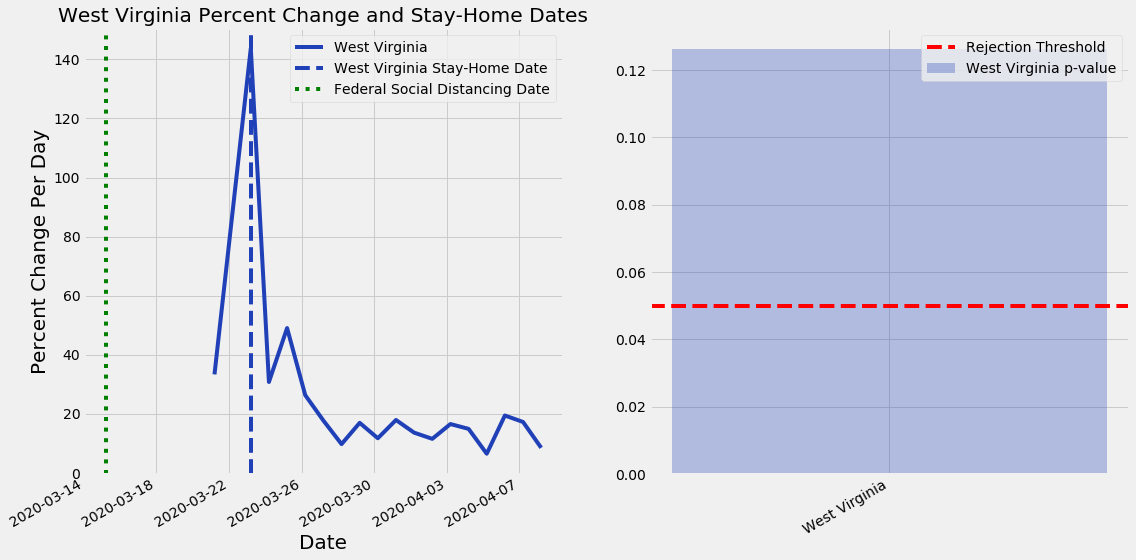

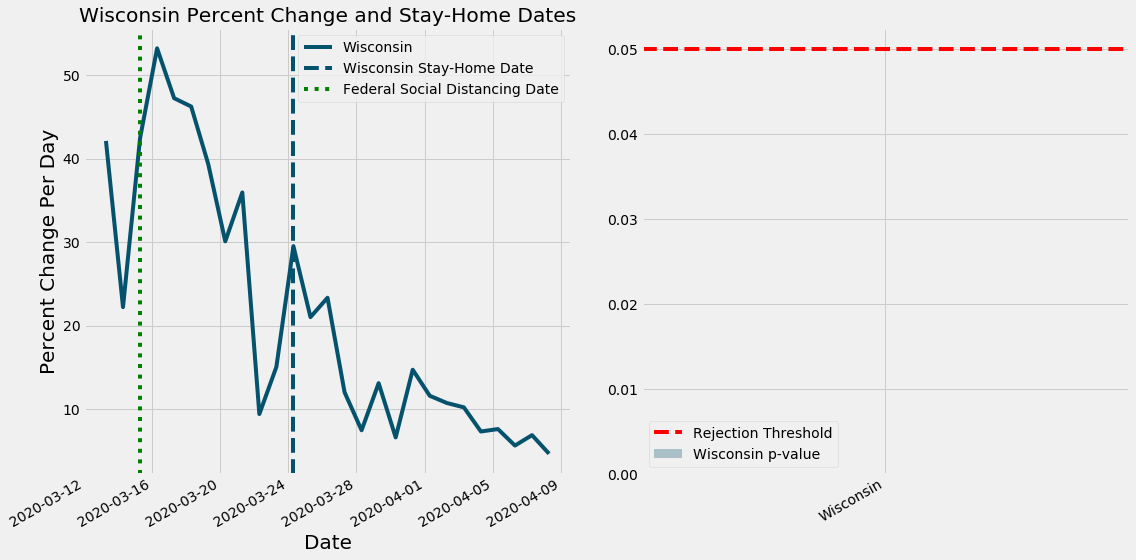

In [14]:
for each_state in all_states:
    i=0 #counter for the axes
    
    #generate a new plot to plot on
    fig, axs = plt.subplots(1, 2, figsize=(16,8), sharex = False, sharey = False)
    ax = axs.flatten()

    #plot percent change
    each_state.plot_percent_changes(ax[i])
    plot_social_distance(ax[i], get_social_distance_date())

    #plot bar graph next to percent change
    each_state.plot_p_value(ax[i+1])
    
    ax[i].set_title('{} Percent Change and Stay-Home Dates'.format(each_state.name))
    generate_labels(ax[i])
    fig.autofmt_xdate()
    fig.tight_layout()
    
    #plt.savefig('figures/{}_states_with_p_value.png'.format(each_state.name))

### Group states with higher than 0.05 p-values

In [14]:
states_reject = []
states_no_reject = []

for each_state in all_states:
    if each_state.p_value > 0.05:
        states_no_reject.append(each_state)
    else:
        states_reject.append(each_state)

#### Plot states that null hypothesis cannot be rejected.

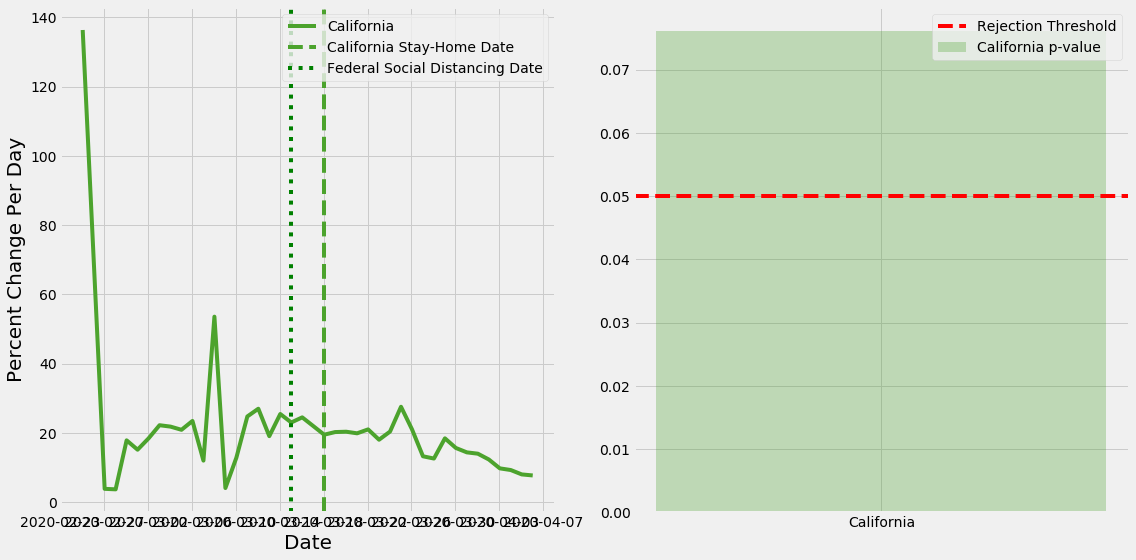

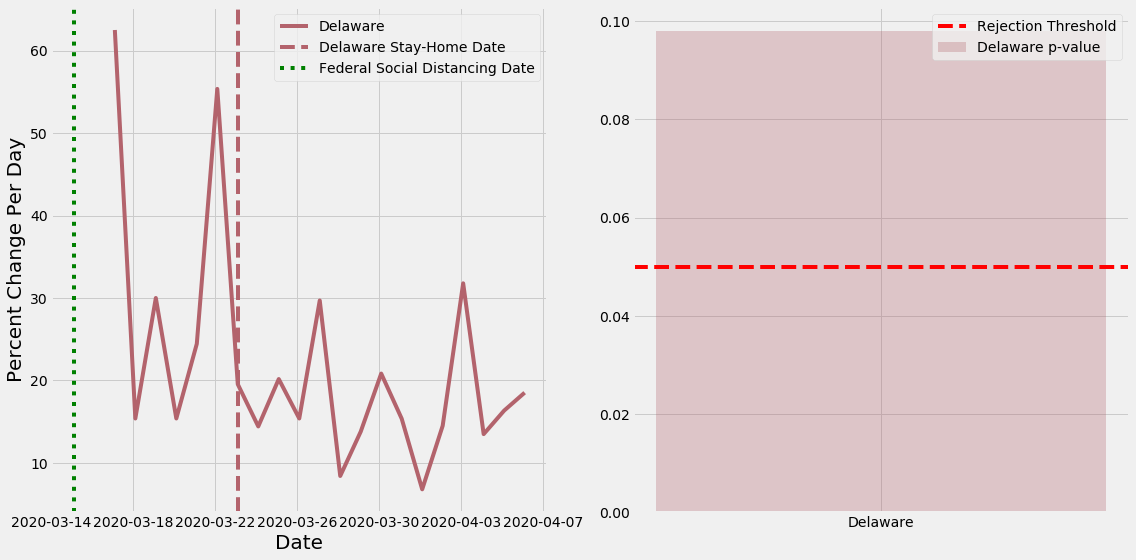

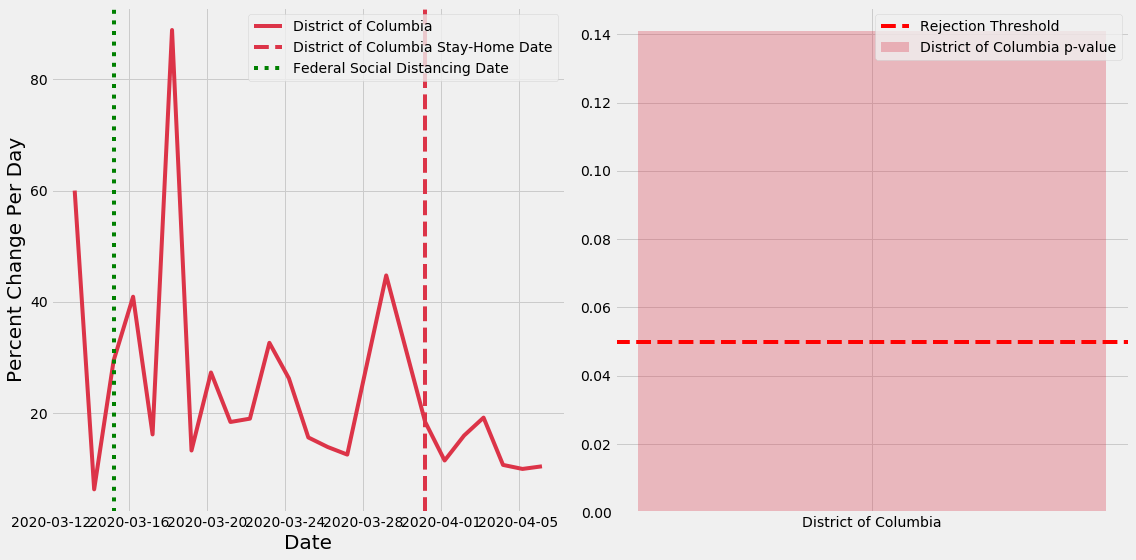

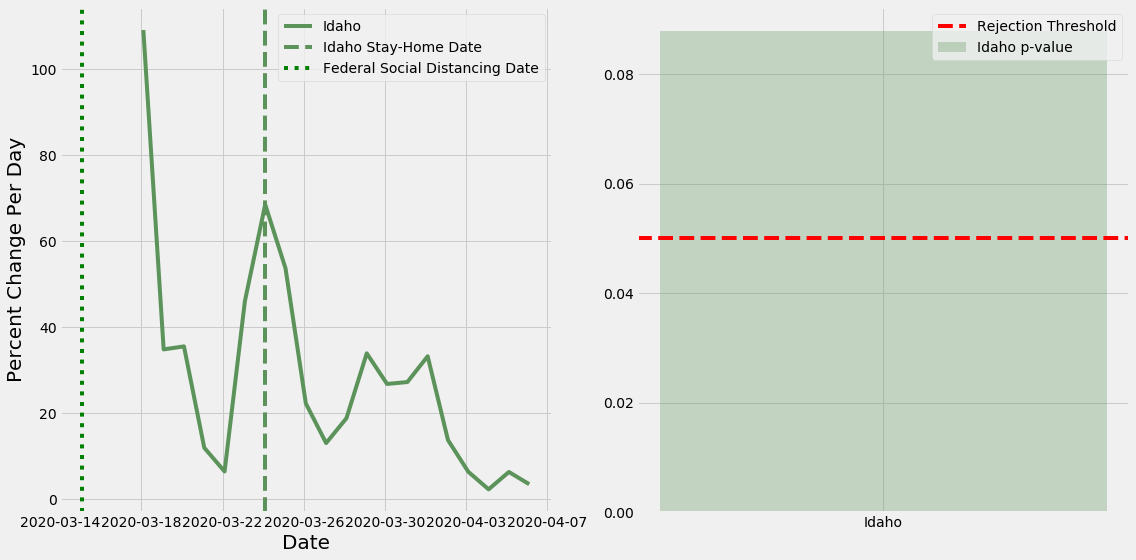

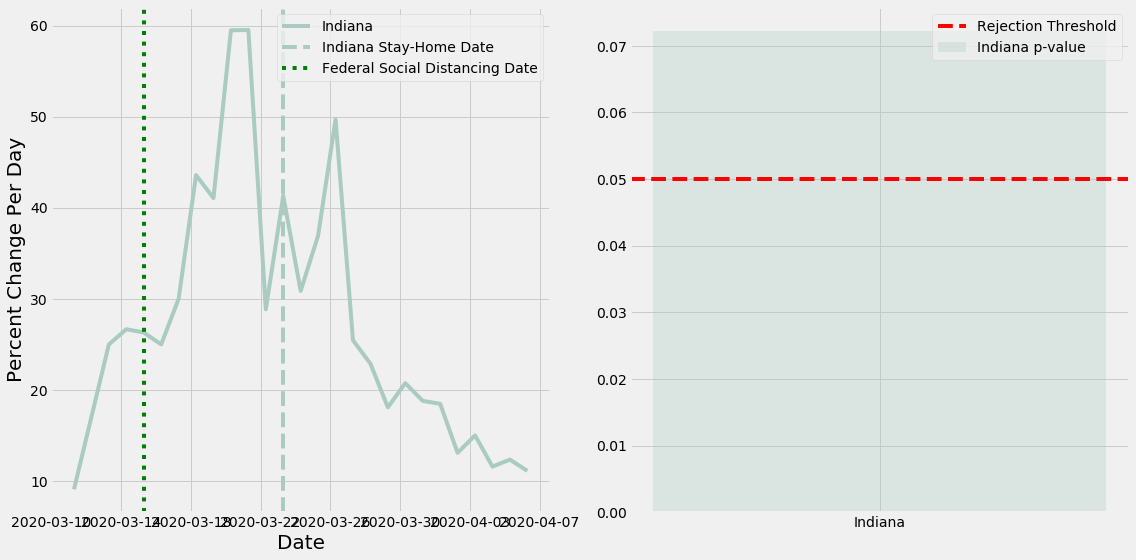

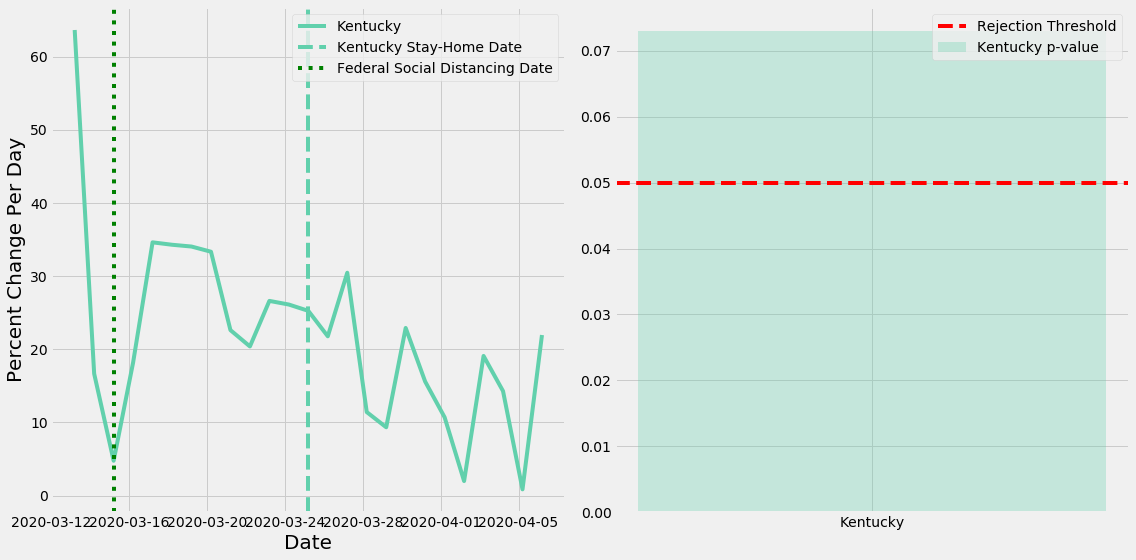

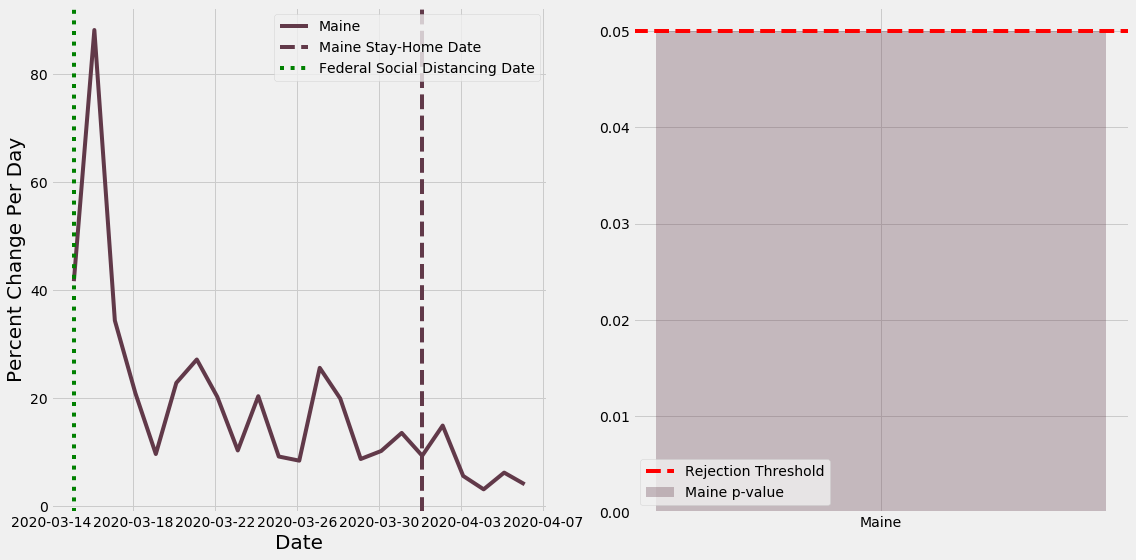

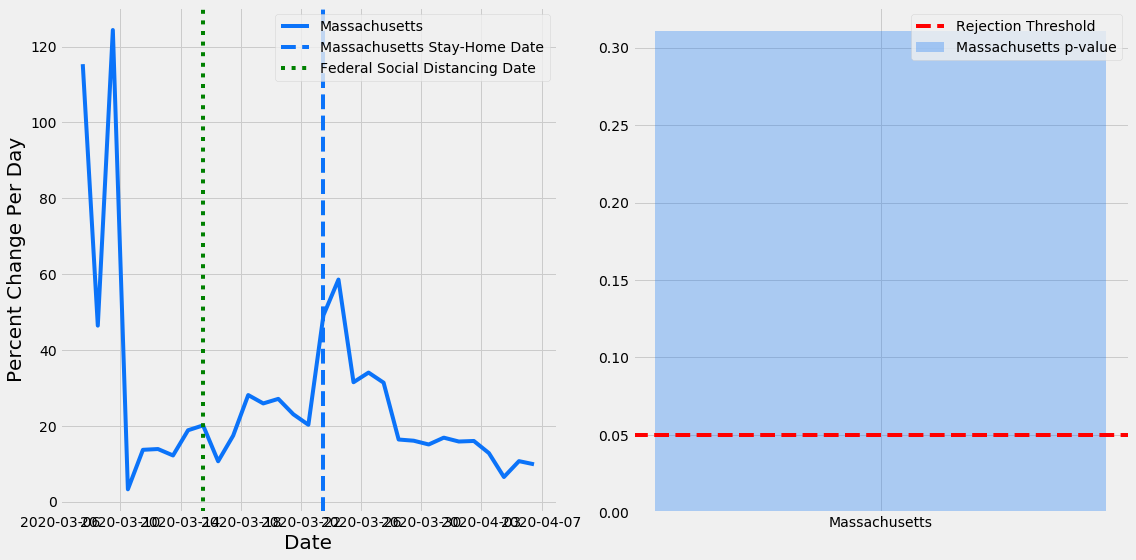

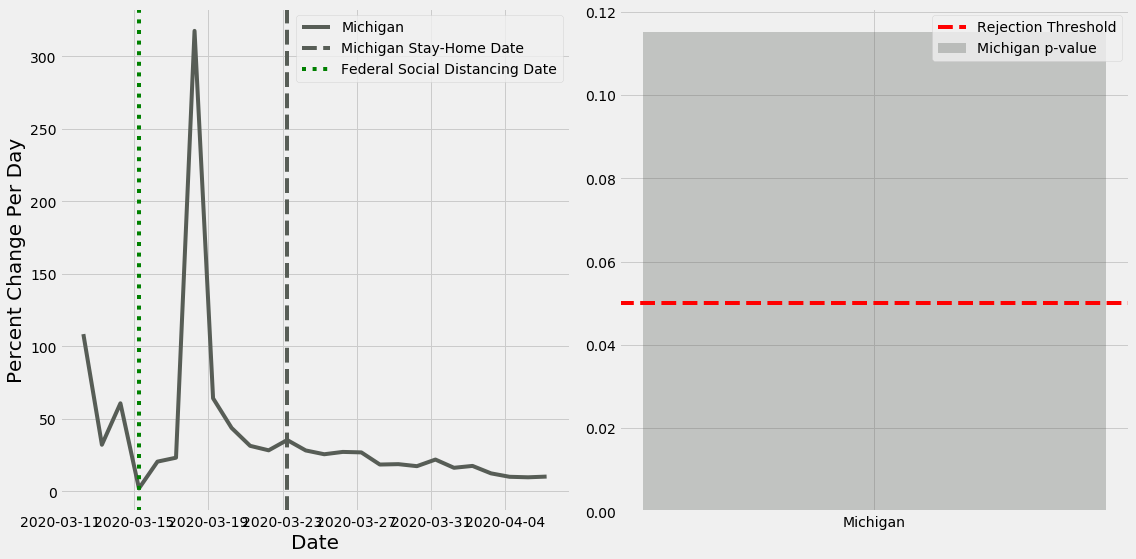

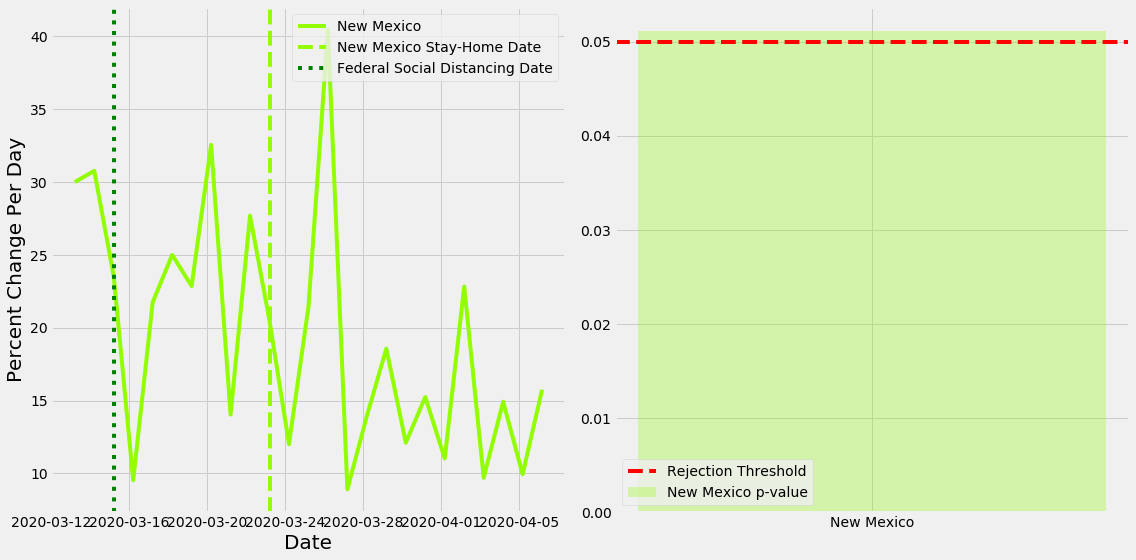

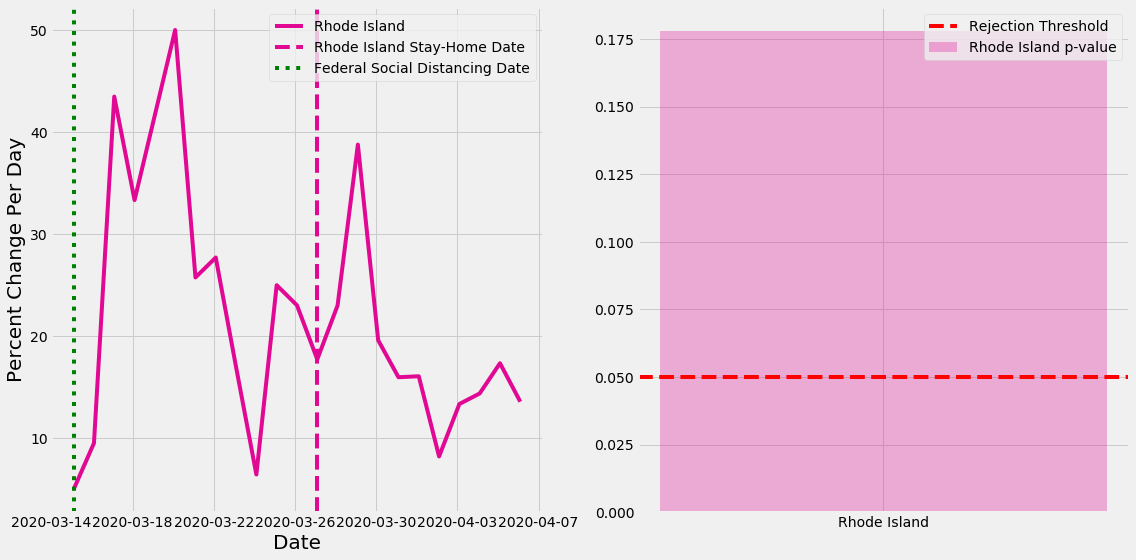

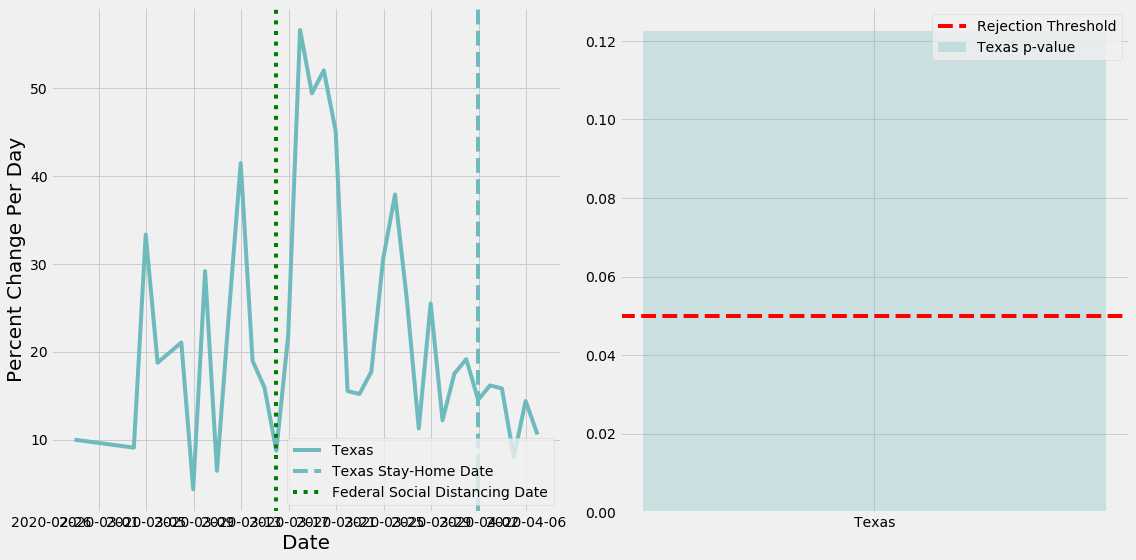

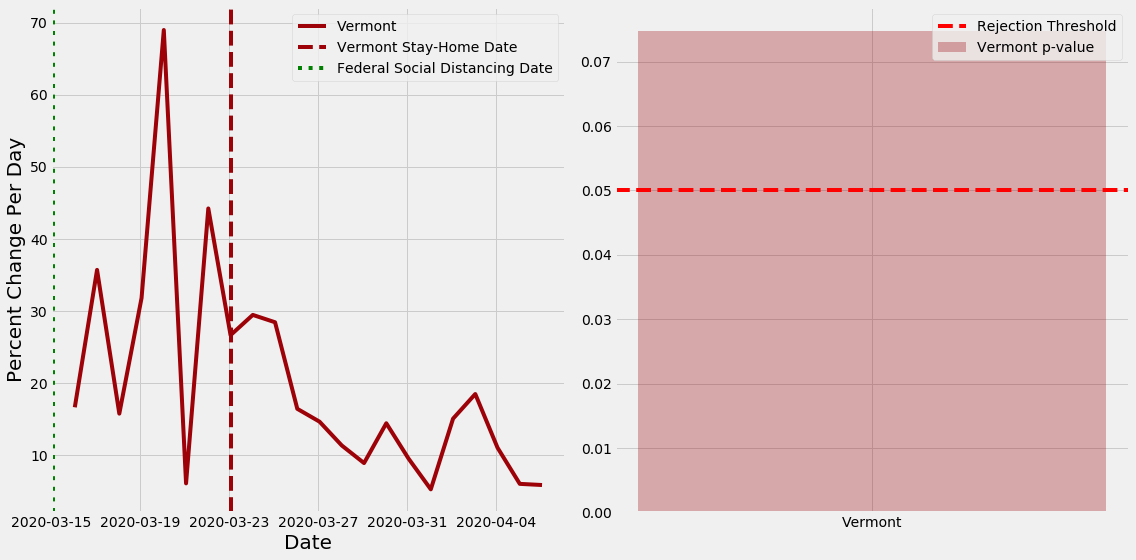

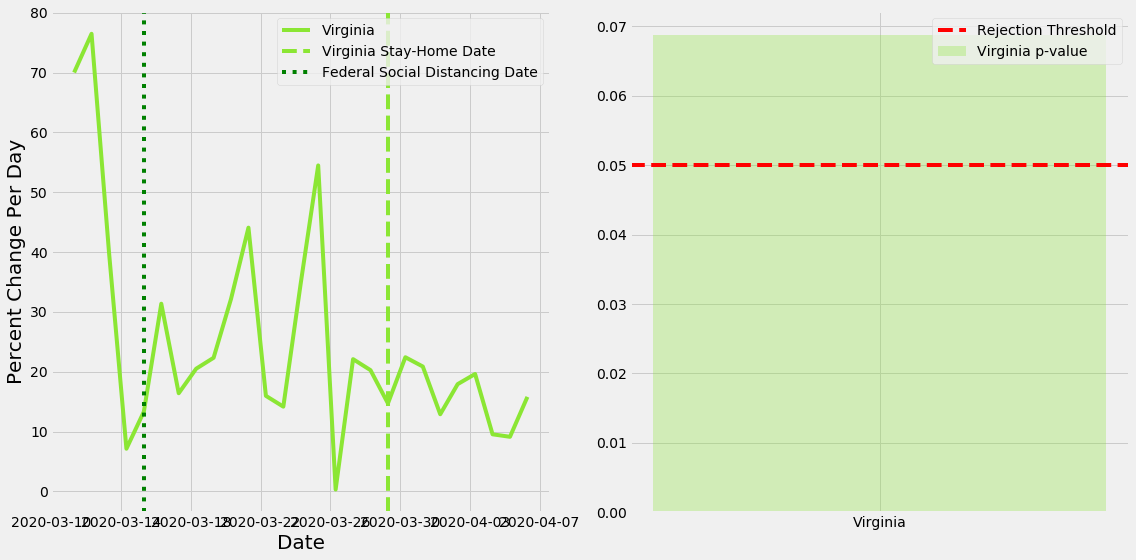

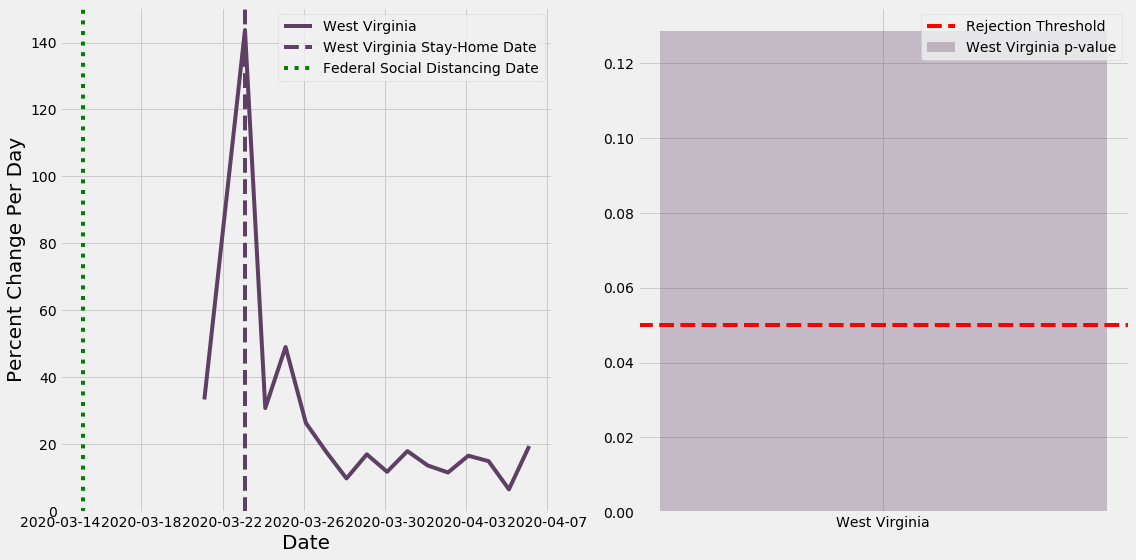

In [15]:
for each_state in states_no_reject:
    
    i = 0 #counter for the axes
    
    fig, axs = plt.subplots(1, 2, figsize=(16,8), sharex = False, sharey = False)
    ax = axs.flatten()
    
    #plot percent change
    each_state.plot_percent_changes(ax[i])
    plot_social_distance(ax[i], get_social_distance_date())
    generate_labels(ax[i])
    
    #plot bar graph next to percent change
    each_state.plot_p_value(ax[i+1])

    fig.tight_layout()